In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import os
import tensorflow as tf
import metrics as mymetrics
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from tensorflow import keras
from joblib import dump, load
%matplotlib inline

# CS5600 Final Project by Jeff Gradner
***
## About
The goal of this project and notebook is to compare the performance of supervised and unsupervised machine learning techniques one classifying treatment outcomes of Bovine Respiratory Disease. The data I'm using can be found in `data/raw_data.csv` and is provided by a Utah feedlot operation.
***
## Preprocesing
I preprocess the data by adding calculated features, removing features, and performing feature engineering with normalization and standardization. 
***
## Visualization
I use Matplotlib to gain insights and visualize the raw data, processed data, individual algorithm results, and comparisons of results from various algorithms. 
***
## Algorithms
I'll use a variety of different techniques and apply cross-validation and hyperparameter tuning where applicable. The supervised and unsupervised methods are listed below. All the supervised algorithms are used for binary classification. From the list of unsupervised techniques, I use Gaussian Mixed Models and K-Means for classification and to transform the data into 2-dimensional space for visualization. Primary Component Analysis (PCA) and Kernel PCA are used strictly for visualization. I attempt to project the data onto 2-dimensions and had it been successful the task of classification would've become trival. The original data is not linearly separable and you'll see that even with non-linear transformations the projected data is still not separable.
### Supervised
* Random Forests (RF)
* AdaBoost (Ada)
* Support Vector Machines (SVM)
* Logistic Regression (LR)
* Neural Networks (NN)

### Unsupervised
* Gaussian Mixed Models (GMM)
* K-Means (KMeans)
* Primary Component Analysis (PCA)
* Kernel Primary Component Analysis (KPCA)
***
## Table of Contents
### [Preprocessing](#preprocessing)
* [Raw Data Visualization](#rawDataVis)
* [Feature Engineering](#featureengineering)
* [Splitting the Data](#splitting)
***
### [Supervised Algorithms](#supervised) 
* [Random Forest](#rf)
* [AdaBoost](#ada)
* [Support Vecor Machines](#svm)
* [Logistic Regression](#lr)
* [Neural Network](#nn)
***    
### [Unsupervised Algorithms](#unsupervised)
* [Gaussian Mixed Models](#gmm)
* [K-Means](#kmean)
* [Primary Component Analysis](#pca)
* [Kernel Primary Component Analysis](#kpca)
***        
### [Results](#results)
* [ROC Curves](#roc)
* [Metric Comparisons](#metricComparisons)

<a id="preprocessing"></a>
# Preprocessing
***

<a id="rawDataVis"></a>
## Raw Data Visualization

Below I'm reading the original data into a Pandas DataFrame and assign the dtype to each column based on observing the data in a spreadsheet.

In [60]:
df_raw = pd.read_csv('data/raw_data.csv', dtype={'yard.lot.tag.date':'object',
                                                            'Yard.Lot': 'object',
                                                            'yard.lot.tag':'object',
                                                            'Yard': 'string',
                                                            'Lot': 'string',
                                                            'Treat.Date':'string',
                                                            'Drug': 'string',
                                                            'Treat.Weight':'int64',
                                                            'Treat.Temperature':'float64',
                                                            'Sex': 'string',
                                                            'Treatment.Number':'int64',
                                                            'Head.Received': 'int64',
                                                            'Arrival.Date': 'string',
                                                            'Arrival.Weight':'float64',
                                                            'Death.Date':'object',
                                                            'Cause.Of.Death':'object'},)

## Plotting of the Raw Data

### Quantity of Deaths by Cause per Gender
I see that both male and female cows die majorily from respiratory problems and that more males die than females. H is for hefer and S is for steer.

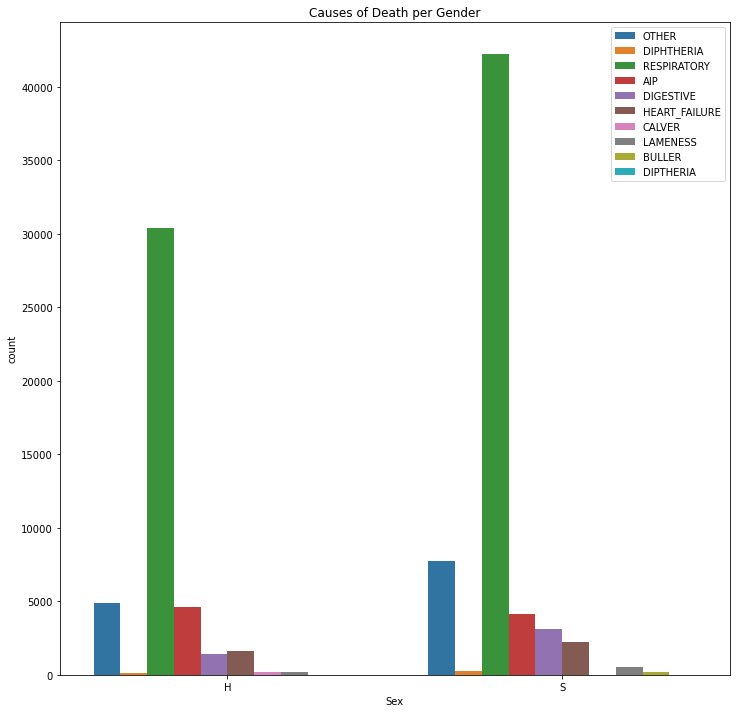

In [61]:
plt.figure(figsize=(12,12))
sns.countplot(x='Sex', hue ='Cause.Of.Death', data=df_raw)
plt.title('Causes of Death per Gender')
plt.legend(loc='best')
plt.show()

### Quantity of Causes of Death per Drug Type
I'm checking for the the largest causes of death, RESPIRATORY, AIP, and OTHER, how many die while being treated with a given drug. 

Below I'm filtering the data to only include examples where the cause of death is one of the 3 top contributors.

In [62]:
df_respiratory = df_raw.loc[df_raw['Cause.Of.Death'] == 'RESPIRATORY']
df_aip = df_raw.loc[df_raw['Cause.Of.Death'] == 'AIP']
df_other = df_raw.loc[df_raw['Cause.Of.Death'] == 'OTHER']
df_deaths_drugs = pd.concat([df_respiratory, df_aip, df_other], axis=0)

Plotting the number of deaths for each cause of death and with what treatment drug was used.

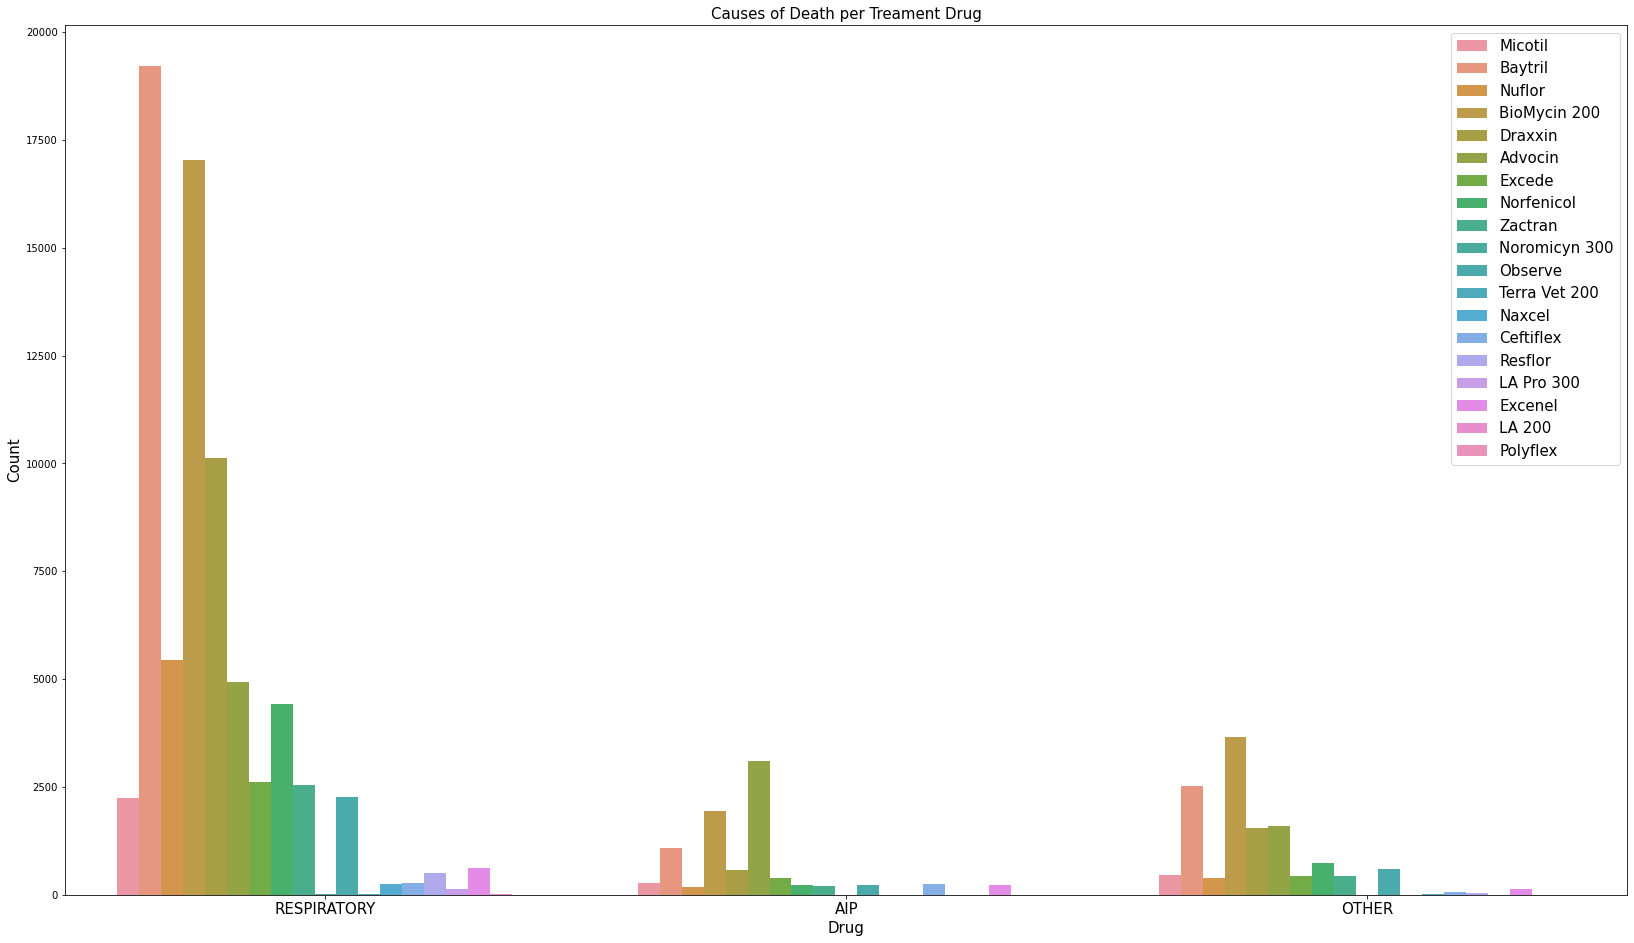

In [63]:
plt.figure(figsize=(28,16))
sns.countplot(x='Cause.Of.Death', hue ='Drug', data=df_deaths_drugs)
plt.title('Causes of Death per Treament Drug',fontsize=15)
plt.legend(loc='upper right',prop={'size':'15'})
plt.xlabel('Drug', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Raw Data Insights

Below is the shape of the original data and a sample of 3 examples.

In [64]:
print("Original data shape:", df_raw.shape)
df_raw.sample(3)

Original data shape: (637742, 16)


,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death
212382,1011.9038.386635.2019-05-10,1011.9038,1011.9038.386635,1011,9038,5/10/2019,BioMycin 200,901,103.4,S,1,191,4/24/2019,843.0,NaN,NaN
215502,1011.98.N107.2016-07-08,1011.98,1011.98.N107,1011,98,7/8/2016,Draxxin,962,105.3,S,1,226,6/7/2016,860.0,NaN,NaN
595271,1034.2463.463567.2019-11-27,1034.2463,1034.2463.463567,1034,2463,11/27/2019,Draxxin,853,104.7,S,1,120,8/29/2019,700.0,NaN,NaN


I'm checking if there are any null values and how many of each there are. I see that there are missing values for the Death Date and Cause of Death, this makes sense because not every animal who is treated for Bovine Respiratory Disease dies.

In [65]:
df_raw.isna().sum()

yard.lot.tag.date         0
Yard.Lot                  0
yard.lot.tag              0
Yard                      0
Lot                       0
Treat.Date                0
Drug                      0
Treat.Weight              0
Treat.Temperature         0
Sex                       0
Treatment.Number          0
Head.Received             0
Arrival.Date              0
Arrival.Weight            0
Death.Date           533913
Cause.Of.Death       533913
dtype: int64

Checking how many deaths per Cause of Death. The majority of deaths reported are attributed to respiratory.

In [66]:
df_raw['Cause.Of.Death'].value_counts()

RESPIRATORY      72697
OTHER            12650
AIP               8704
DIGESTIVE         4493
HEART_FAILURE     3851
LAMENESS           663
DIPHTHERIA         388
BULLER             198
CALVER             180
DIPTHERIA            5
Name: Cause.Of.Death, dtype: int64

Viewing how many of each sex exist in the data. 

In [67]:
df_raw['Sex'].value_counts()

S    409015
H    228727
Name: Sex, dtype: Int64

Viewing descriptive statistics from the original data.

In [68]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Treat.Weight,637742.0,808.029455,212.499837,-1114.0,662.0,789.0,933.0,9955.0
Treat.Temperature,637742.0,104.402306,2.381540,1.0,103.9,104.4,105.1,678.0
Treatment.Number,637742.0,1.476127,0.837107,1.0,1.0,1.0,2.0,20.0
Head.Received,637742.0,232.000260,168.899591,1.0,138.0,202.0,278.0,2171.0
Arrival.Weight,637742.0,718.653705,139.315755,0.0,638.0,724.0,803.0,3482.0


<a id="featureengineering"></a>
## Feature Engineering

### Summary

In this section I add the following features:
* Arrival.Month
* Arrival.Quarter
* Treatment.Month
* Treatment.Quarter
* Brdcasestothispoint
* Distbrdcasestothispoint
* Txfaliures2
* Txfaliures2tothispoint
* Txsuccessrate2
* Propbrdcasestothispoint
* Propdistbrdcasestothispoint
* Dayssincearrival
* Deathstothispoint
* Propdeathstothispoint
* Dailyallpulls
* Propdailyallpulls
* DNF

I fix features like Death.Date and Cause.Of.Death. A single animal could have more than one entry if they were treated more than once, I want every entry for a single animal to have the same value for Death.Date, Cause.Of.Death, and DNF, if applicable (If the cow died).

I add an entry for every animal that died (Did Not Finish ie. DNF = 1) that represents the death event. 

I handle missing data by filling the entries with the weighted mean of the respective feature. The mean essentially tells us nothing when training a model. 

The following features are one-hot encoded:
* Drug
* Sex
* Arrival.Month
* Arrival.Quarter
* Treatment.Month
* Treatment.Quarter

I create two datasets, one that is normalized and the other standardized. For the neural network I use the normalized data and the rest use the standardized data.

In [69]:
df_raw.sample(3)

,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death
624952,77.9Y05.9Y0538592.2019-11-25,77.9Y05,77.9Y05.9Y0538592,77,9Y05,11/25/2019,BioMycin 200,877,103.8,H,1,368,11/11/2019,872.0,NaN,NaN
498848,1029.9101.545506.2019-06-28,1029.9101,1029.9101.545506,1029,9101,6/28/2019,Baytril,350,104.0,S,2,317,6/13/2019,425.0,NaN,NaN
201405,1011.7077.773965.2017-12-07,1011.7077,1011.7077.773965,1011,7077,12/7/2017,Observe,806,102.6,S,2,191,11/8/2017,716.0,NaN,NaN


Feedlots are made up of yards that contain lots where the animals reside. Each animal has a unique tag. Below I'm taking the series of yard.lot.tag and splitting the data where there are periods to create three series for the yard, lot, and tag. I'm then combining yard and tag into one series named Yard.Tag adding it to the DataFrame and removing the yard and tag columns.

In [70]:
ylt = df_raw['yard.lot.tag']
ylt = ylt.str.split( '.', expand= True)
ylt.rename(columns = {0:'yard', 1:'lot', 2:'tag'}, inplace = True)
df_raw['yard'] = ylt['yard']
df_raw['tag'] = ylt['tag']
df_raw['Yard.Tag'] = df_raw['yard'] + '.' + df_raw['tag']
df_raw = df_raw.drop(['yard', 'tag'], axis = 1)

A target column doesn't exist in the raw data so I'm going to add one named DNF for Did Not Finish. If an example has 0 for its DNF value then the animal finished or lived. If DNF has a value of 1 then that animal died. I construct the DNF series by inserting the value 0 if there is no death date, otherwise 1.

In [71]:
df_raw['DNF'] = ''
df_raw['DNF'] = np.where(pd.isna(df_raw['Death.Date']), 0, 1)

Thinking that the time of year an animal arrives on the feedlot and gets sick could be useful I'm adding features for the arrival month and quarter, and the treat month and quarter. I'm using Pandas to parse the month and quarter from the exising arrival and treat dates. 

In [72]:
df_raw['Arrival.Month'] = pd.DatetimeIndex(df_raw['Arrival.Date']).month
df_raw['Arrival.Quarter'] = pd.DatetimeIndex(df_raw['Arrival.Date']).quarter
df_raw['Treat.Month'] = pd.DatetimeIndex(df_raw['Treat.Date']).month
df_raw['Treat.Quarter'] = pd.DatetimeIndex(df_raw['Treat.Date']).quarter

There will be examples that have the same Yard.Lot if they are treated more than once or are treated once and do not finish. I want all instances for a particular animal to reflect whether they died or not. For example if an animal is treated two times and there is a third input vector that reflects that the animal died then I want all of the instances for that animal to have a DNF value of 1. Below I sort the raw data by Yard.Lot and Treat.Date, I then get a boolean series where examples that have a dupilcate are marked True. These examples that are marked True reflect the cows that need to have their DNF values updated to match the end result for that animal. I then access the raw data with the boolean series and group by the Yard.Lot and Yard.Tag meaning I'm grouping all instances for each unique animal. I then access those groups at their DNF values and apply transform to each group so that if there is a value 1 in any of a groups DNF then all will have the value 1 for DNF. This returns a boolean series where True indicates that all the values were set to 1 and False means the cow finished and all examples for that cow have a DNF of 0. I used this boolean series to update the DNF column as integers 0 or 1.

In [73]:
df_raw = df_raw.sort_values(['Yard.Lot', 'Treat.Date'])
dup = df_raw.duplicated(['Yard.Lot', 'Yard.Tag'], keep=False)
fixed_dnf = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['DNF'].transform(any)
df_raw['DNF'].update(fixed_dnf.astype(int))

Similar to how I want the DNF value to be the same for all examples given a single unique animal I want the death date and cause of death to match for all examples of an animal. Below I use the boolean series `dup` from above which indicated which examples have duplicates or which animals have more than entry in the data. I then group by Yard.Lot and Yard.Tag again where each group consists of examples for a single animal and take the animal death date and fill backwards from the example so that all entries for a single animal have the same death date and then also fill forwards to ensure that any entries after the one marked with the death date also have the death date value. I repeat this process for the cause of death.  

In [74]:
death_date_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='bfill')
df_raw['Death.Date'].update(death_date_fixed1)
death_date_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='ffill')
df_raw['Death.Date'].update(death_date_fixed2)

death_cause_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='bfill')
df_raw['Cause.Of.Death'].update(death_cause_fixed1)
death_cause_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='ffill')
df_raw['Cause.Of.Death'].update(death_cause_fixed2)

So far all of the examples represent a treatment of a given animal and I want to make sure that the treatment number is correct for all examples. I again use the boolean series dup to get all the instances where they belong to an animal who have more than one entry in the data and group by the Yard.Lot and Yard.Tag and number each item in each group $0$ to $(len(group)-1)$ with Pandas cumcount() function. A treament number wouldn't ever be 0 the first treatment should have a treatment number of 1 so I increment all the values by 1. Finally the Treatment.Number column is replaced with the updated treatment number values.

In [75]:
fixed_treat = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag']).cumcount()
fixed_treat += 1
df_raw['Treatment.Number'] = fixed_treat

Adding a new row for the death event of each animal if they did not finish. I'm creating a DataFrame of all the examples where the death date is not null and dropping and duplicates of Yard.Lot and Yard.Tag so that the data has one example for each animal that did not finish. Set the treat date equal to the death date because these rows are the death event not a treatment instance. I also set the drug, treat weight, and treat temperature to null (nan). 

In [76]:
df_dnf = df_raw.loc[df_raw['Death.Date'].notna()].drop_duplicates(['Yard.Lot', 'Yard.Tag'])
df_dnf['Treat.Date'] = df_dnf['Death.Date']
df_dnf.loc[:,['Drug', 'Treat.Weight','Treat.Temperature']] = np.nan

Concatenating the death events to the raw data and sorting by Yard.Lot and Treat.Date to observe if it looks correct. It does and then I reset the index after sorting the DataFrame.

In [77]:
df = pd.concat([df_raw, df_dnf], ignore_index=True)
df = df.sort_values(['Yard.Lot', 'Treat.Date'])
df = df.reset_index(drop=True)

Adding another feature Brdcasestothispoint that is the number of BRD cases in a given lot for each example. 

In [78]:
df.loc[:,'Brdcasestothispoint'] = df.groupby(df['Yard.Lot']).cumcount()

Adding another feature that is the number of distinct cases of BRD for a given lot.

In [79]:
unique_cases = df.drop_duplicates(['Yard.Lot', 'Yard.Tag']).groupby(df['Yard.Lot']).cumcount()
distbrd = unique_cases.reindex(df.index).ffill().astype(int)
df['Distbrdcasestothispoint'] = distbrd

Adding two more features, one for the total treatment failures and another for the treatment failures for a given lot

In [80]:
dup = df.duplicated(['Yard.Lot', 'Yard.Tag'])
df['Txfailure2'] = dup.astype(int)
failtothispoint = df.groupby(df['Yard.Lot']).cumsum()['Txfailure2']
df['Txfailure2tothispoint'] = failtothispoint

Adding another feature that is the treatment success rate for a given lot. 

In [81]:
success_rate = (df['Distbrdcasestothispoint']-df['Txfailure2tothispoint'])/df['Distbrdcasestothispoint']
success_rate = success_rate.fillna(1)
success_rate = success_rate.replace(np.NINF, 1)
success_rate = success_rate.replace(np.inf, 1)
df['Txsuccessrate2'] = success_rate

Adding two more features, one for the proportion of BRD cases and another for the proportion of distinct BRD cases for a given lot. 

In [82]:
df['Propbrdcasestothispoint'] = df['Brdcasestothispoint']/df['Head.Received']
df['Propdistcasestothispoint'] = df['Distbrdcasestothispoint']/df['Head.Received']

Adding a days since arrival feature to determine how long the animal has been in the feedlot.

In [83]:
df['Dayssincearrival'] = (pd.to_datetime(df['Treat.Date'])-pd.to_datetime(df['Arrival.Date'])).dt.days

Adding two more features, the amount of deaths and the proportion of deaths.

In [84]:
dnf = df.loc[df['Death.Date'].notna()]
deathcount = df.groupby(df['Yard.Lot'])['DNF'].cumsum()
df['Deathstothispoint'] = deathcount
df['Propdeathstothispoint'] = df['Deathstothispoint']/df['Head.Received']

Adding two more features, the number of animals that were pulled and treated on a given day for a lot and the proportion of pulls for that lot. 

In [85]:
df['Dailyallpulls'] = df.groupby(['Yard.Lot', 'Treat.Date'])['Treat.Date'].transform('size')
df['Propdailyallpulls'] = df['Dailyallpulls']/df['Head.Received']

Viewing a sample of the data.

In [86]:
df.sample(3)

,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,...,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls
594534,1031.7121.4999G.2017-11-22,1031.7121,1031.7121.4999G,1031,7121,11/22/2017,Micotil,490.0,105.3,S,...,0,6,0.846154,0.171756,0.148855,27,8,0.030534,5,0.019084
494114,1028.8408.644712.2018-12-19,1028.8408,1028.8408.644712,1028,8408,12/19/2018,BioMycin 200,1139.0,103.7,S,...,0,1,0.833333,0.032258,0.027650,187,2,0.009217,1,0.004608
7522,1001.8669.1738669.2017-10-11,1001.8669,1001.8669.1738669,1001,8669,10/11/2017,Baytril,614.0,105.0,H,...,0,2,0.904762,0.125683,0.114754,28,14,0.076503,26,0.142077


Dropping columns from the data I won't use or need.

In [87]:
df_reduced = df.drop(['yard.lot.tag.date','Yard', 'Yard.Lot','yard.lot.tag', 'Lot', 'Arrival.Date','Yard.Tag','Treat.Date', 'Death.Date', 'Cause.Of.Death'], axis=1)

Creating a dataset with no one hot encoding for dimesionality reduction algorithms.

In [88]:
no_one_hot = df_reduced.copy()

One hot encoding nominal features and viewing a sample of the data.

In [89]:
df_one_hot = pd.get_dummies(data=df_reduced, columns=['Arrival.Month', 'Arrival.Quarter', 'Treat.Month', 'Treat.Quarter', 'Drug', 'Sex'])
pd.set_option('display.max_columns', 79)
df_one_hot.sample(5)

,Treat.Weight,Treat.Temperature,Treatment.Number,Head.Received,Arrival.Weight,DNF,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls,Arrival.Month_1,Arrival.Month_2,Arrival.Month_3,Arrival.Month_4,Arrival.Month_5,Arrival.Month_6,Arrival.Month_7,Arrival.Month_8,Arrival.Month_9,Arrival.Month_10,Arrival.Month_11,Arrival.Month_12,Arrival.Quarter_1,Arrival.Quarter_2,Arrival.Quarter_3,Arrival.Quarter_4,Treat.Month_1,Treat.Month_2,Treat.Month_3,Treat.Month_4,Treat.Month_5,Treat.Month_6,Treat.Month_7,Treat.Month_8,Treat.Month_9,Treat.Month_10,Treat.Month_11,Treat.Month_12,Treat.Quarter_1,Treat.Quarter_2,Treat.Quarter_3,Treat.Quarter_4,Drug_Advocin,Drug_Baytril,Drug_BioMycin 200,Drug_Ceftiflex,Drug_Draxxin,Drug_Excede,Drug_Excenel,Drug_LA 200,Drug_LA 300,Drug_LA Pro 300,Drug_Micotil,Drug_Naxcel,Drug_Norfenicol,Drug_Noromicyn 300,Drug_Nuflor,Drug_Observe,Drug_Polyflex,Drug_Resflor,Drug_Terra Vet 200,Drug_Zactran,Sex_H,Sex_S
610493,750.0,103.5,1.0,159,647.0,0,29,21,0,8,0.619048,0.182390,0.132075,41,0,0.000000,1,0.006289,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
331049,777.0,105.2,NaN,472,798.0,1,7,6,0,1,0.833333,0.014831,0.012712,7,3,0.006356,2,0.004237,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
664196,1194.0,103.9,NaN,324,764.0,1,0,0,0,0,1.000000,0.000000,0.000000,170,1,0.003086,1,0.003086,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
623761,538.0,106.2,2.0,220,683.0,0,80,47,1,33,0.297872,0.363636,0.213636,19,49,0.222727,2,0.009091,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
252436,730.0,106.7,NaN,242,808.0,0,2,2,0,0,1.000000,0.008264,0.008264,2121,1,0.004132,1,0.004132,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Filtering out the numeric features for feature engineering and viewing a sample.

In [90]:
numeric_features = df_one_hot.drop(df_one_hot.iloc[:,17:], axis=1)
numeric_features.drop(columns=['DNF'], axis=1, inplace=True)
numeric_features.sample(5)

,Treat.Weight,Treat.Temperature,Treatment.Number,Head.Received,Arrival.Weight,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls
397062,1000.0,103.7,2.0,321,647.0,24,10,1,14,-0.400000,0.074766,0.031153,151,13,0.040498,2
197869,682.0,104.4,2.0,143,791.0,3,1,1,2,-1.000000,0.020979,0.006993,33,2,0.013986,1
359029,710.0,103.8,2.0,149,662.0,33,26,1,7,0.730769,0.221477,0.174497,14,7,0.046980,6
649029,541.0,104.0,NaN,120,667.0,19,15,0,4,0.733333,0.158333,0.125000,7,4,0.033333,2
264094,667.0,104.1,NaN,96,627.0,29,25,0,4,0.840000,0.302083,0.260417,11,0,0.000000,2


Statistical details of the numeric features.

In [91]:
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Treat.Weight,637742.0,808.029455,212.499837,-1114.0,662.000000,789.000000,933.000000,9955.000000
Treat.Temperature,637742.0,104.402306,2.381540,1.0,103.900000,104.400000,105.100000,678.000000
Treatment.Number,316952.0,1.752300,0.862325,1.0,1.000000,2.000000,2.000000,11.000000
Head.Received,695716.0,232.950889,169.506711,1.0,139.000000,203.000000,279.000000,2171.000000
Arrival.Weight,695716.0,717.855347,139.100569,0.0,638.000000,723.000000,802.000000,3482.000000
Brdcasestothispoint,695716.0,33.695496,50.729922,0.0,6.000000,16.000000,40.000000,753.000000
Distbrdcasestothispoint,695716.0,23.751988,32.389729,0.0,4.000000,12.000000,30.000000,422.000000
Txfailure2,695716.0,0.328259,0.469580,0.0,0.000000,0.000000,1.000000,1.000000
Txfailure2tothispoint,695716.0,9.943509,20.188924,0.0,1.000000,3.000000,10.000000,341.000000
Txsuccessrate2,695716.0,0.649426,0.392056,-6.0,0.500000,0.733333,0.950000,1.000000


Checking for null or missing data from the numeric features.

In [92]:
numeric_features.isna().sum()

Treat.Weight                 57974
Treat.Temperature            57974
Treatment.Number            378764
Head.Received                    0
Arrival.Weight                   0
Brdcasestothispoint              0
Distbrdcasestothispoint          0
Txfailure2                       0
Txfailure2tothispoint            0
Txsuccessrate2                   0
Propbrdcasestothispoint          0
Propdistcasestothispoint         0
Dayssincearrival                 0
Deathstothispoint                0
Propdeathstothispoint            0
Dailyallpulls                    0
dtype: int64

Filling missing data with the mean of the feature it belongs to. The mean doesn't tell us anything statisically speaking

In [93]:
numeric_features['Treat.Weight'].fillna(value=numeric_features['Treat.Weight'].mean(), inplace=True)
numeric_features['Treat.Temperature'].fillna(value=numeric_features['Treat.Temperature'].mean(), inplace=True)
numeric_features['Treatment.Number'].fillna(value=numeric_features['Treatment.Number'].mean(), inplace=True)

no_one_hot['Treat.Weight'].fillna(value=no_one_hot['Treat.Weight'].mean(), inplace=True)
no_one_hot['Treat.Temperature'].fillna(value=no_one_hot['Treat.Temperature'].mean(), inplace=True)
no_one_hot['Treatment.Number'].fillna(value=no_one_hot['Treatment.Number'].mean(), inplace=True)

Using scikit-learn I'm going to normalize and standardize the numeric features. I'll create two datasets so that I can use the scaled or nomalized data depending on the algorithm. I'm storing the numeric feature column names so I can reconstruct a DataFrame with the transformed datasets.

In [94]:
numeric_column_labels = numeric_features.columns
normed_features = preprocessing.normalize(numeric_features)
df_normed = pd.DataFrame((normed_features), columns=numeric_column_labels)
scaled_features = preprocessing.scale(numeric_features)
df_scaled = pd.DataFrame((scaled_features), columns = numeric_column_labels)

Combining the transformed data from above with the nominal features that were one-hot encoded and saving them to CSV files.

In [95]:
normed_processed = pd.concat([df_normed, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
scaled_processed = pd.concat([df_scaled, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
normed_processed.to_csv('data/normed_processed_data.csv', index=False)
scaled_processed.to_csv('data/scaled_processed_data.csv', index=False)

In [96]:
dnf_tmp = no_one_hot["DNF"]
no_one_hot = no_one_hot.drop(("DNF"), axis=1)

In [97]:
no_one_hot["Drug"] = no_one_hot["Drug"].astype('category').cat.codes

In [98]:
no_one_hot = pd.concat((no_one_hot, dnf_tmp), axis=1)

In [99]:
no_one_hot["Sex"] = no_one_hot["Sex"].astype('category').cat.codes

In [100]:
no_one_hot.to_csv('data/no_one_hot_data.csv', index=False)

<a id="splitting"></a>
# Splitting the Data

Splitting the data into a training, validation and testing set with scikit-learn. Below I store the targets in a flattened array named target.

In [101]:
df_normed = pd.read_csv('data/normed_processed_data.csv')
df_scaled = pd.read_csv('data/scaled_processed_data.csv')

In [102]:
target_n = df_normed[['DNF']]
target_s = df_scaled[['DNF']]

Splititng the normalized data into a training and testing set with an 80-20 split.

In [103]:
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(df_normed.iloc[:, :-1], 
                                                    target_n, 
                                                    test_size = 0.35, 
                                                    random_state=8)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(df_scaled.iloc[:, :-1], 
                                                    target_s, 
                                                    test_size = 0.3, 
                                                    random_state=8)

Splitting the training data into a training and validation sets with a 85-15 split.

In [104]:
x_train_n, x_val_n, y_train_n, y_val_n = train_test_split(x_train_n, 
                                                  y_train_n, 
                                                  test_size=0.2,
                                                  random_state=10)
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_train_s, 
                                                  y_train_s, 
                                                  test_size=0.2,
                                                  random_state=10)

Displaying the size of each dataset.

In [6]:
print("Train Inputs Shape:", x_train_n.shape, "| Val Inputs Shape:", x_val_n.shape, "| Test Inputs Shape:", x_test_n.shape)
print("Train Target Shape:", y_train_n.shape, " | Val Target Shape:", y_val_n.shape, " | Test Target Shape:", y_test_n.shape)

Train Inputs Shape: (361772, 71) | Val Inputs Shape: (90443, 71) | Test Inputs Shape: (243501, 71)
Train Target Shape: (361772, 1)  | Val Target Shape: (90443, 1)  | Test Target Shape: (243501, 1)


<a id="supervised"></a>
# Supervised Algorithms 

<a id="rf"></a>
## Random Forests
From scikit-learn I'm going to use Random Forests. Below I create a list of possible values for the number of estimators to consider.

In [7]:
N = np.arange(100,251,step=50)

Using cross-validation to determine the best number of esimators. For every value n in N I instantiate the Random Forest Classifier from scikit-learn, fit the model with the training data, then compute the accuracy and error of the model on the validation data.

In [8]:
starttime = time.time()
rf_models = []
rf_val_errors = []
for n in N:
    rf = RF(n_estimators=n, n_jobs=6)
    rf.fit(x_train_s.values, y_train_s.values.ravel())
    rf_models.append(rf)
    rf_val_errors.append(1 - rf.score(x_val_s.values, y_val_s.values))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 133.39618349075317 seconds


Plotting the validation error vs. the number of estimators used. The error $E$ is calculated as $E = 1 - $accuracy.

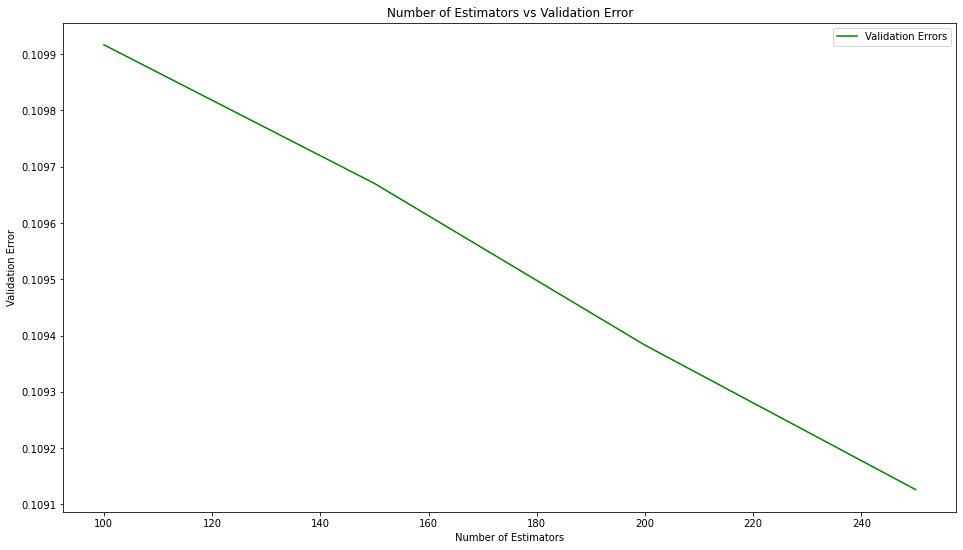

In [9]:
plt.figure(figsize=(16,9))
plt.plot(N,rf_val_errors, 'g-', label='Validation Errors')
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Error')
plt.title('Number of Estimators vs Validation Error')
plt.legend()
plt.show()

Below I'm observing the index that corresponds to the minimum validation error and storing that model in the variable `rf`.

In [13]:
idx = np.argmin(rf_val_errors)
rf = rf_models[2]

The model produced with 250 estimators produced the lowest validation error.

In [14]:
N[idx]

250

Printing results of the Random Forest model being evaluated on the test data.

In [18]:
mymetrics.print_metrics(mymetrics.get_metrics(rf, x_test_s, y_test_s, 'Untuned RF'))

name: 

Untuned RF 

cm: 

actual       0      1
pred                 
0       156702  19291
1         3525  29197 

specificity: 

0.9779999625531277 

sensitivity: 

0.6021489853159545 

precision: 

0.8922743108611944 

accuracy: 

0.8906834678868313 



The training performed pretty slowly so I'm attempting to speed up the training process by reducing the number of samples to be drawn in each bootstrap sample from the total number of examples to 10%, 30%, and 50% of the total number of examples. I'm going to build the model with 250 estimators still and compare the results to the confusion matrix above.

In [19]:
sample_sizes = [.1, .3, .5]

Below I am observing the validation errors produced from models fit with the train data and evaluated on the validation data. Three models are built each with 250 trees in the forest and with bootstrap sample sizes of 10%, 20%, and 30% respectively.

In [21]:
starttime = time.time()
models = []
val_errors = []
for s in sample_sizes:
    rf_smaller_bs_samples = RF(n_estimators=250, n_jobs=4, max_samples=s)
    rf_smaller_bs_samples.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(rf_smaller_bs_samples)
    val_errors.append(1 - rf_smaller_bs_samples.score(x_val_s.values, y_val_s.values))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 68.89317798614502 seconds


Below I observe that the model built with bootstrapped samples having 50% of the total number of examples resulted in the lowest validation error.

In [22]:
idx = np.argmin(val_errors)
sample_sizes[idx]

0.5

Based on the plot below I'm going to use sample sizes of 50% the total number of examples.

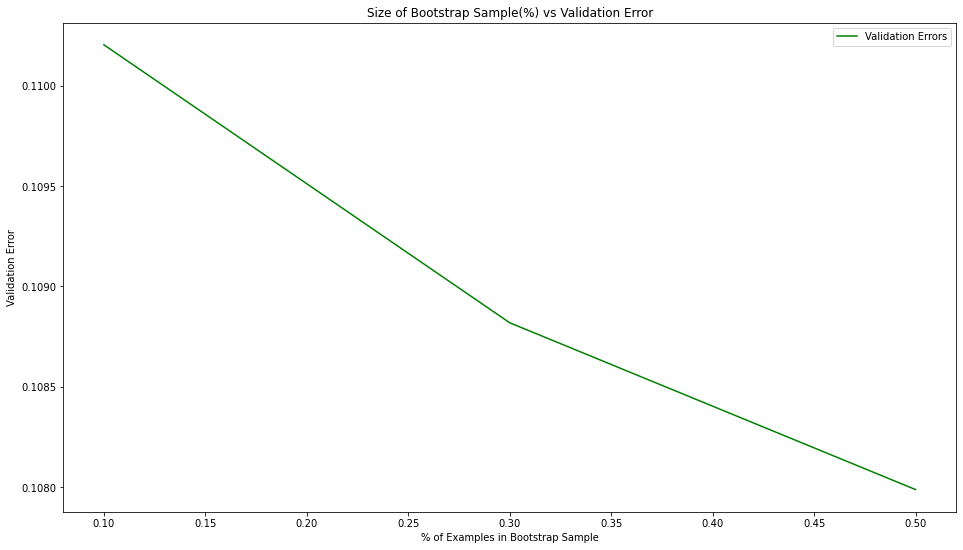

In [23]:
plt.figure(figsize=(16,9))
plt.plot(sample_sizes,val_errors, 'g-', label='Validation Errors')
plt.xlabel('% of Examples in Bootstrap Sample')
plt.ylabel('Validation Error')
plt.title('Size of Bootstrap Sample(%) vs Validation Error')
plt.legend()
plt.show()

The confusion matrix result from evaluating the model built with 250 estimators and bootstrap samples having 50% of the total number of examples in the train data. The confusion matrix appears to have better results than using $N$ examples in the bootstrap samples where $N$ is the number of examples in the train data.

In [24]:
mymetrics.print_metrics(mymetrics.get_metrics(models[idx], x_test_s, y_test_s, 'Sample Size Tuned RF'))

name: 

Sample Size Tuned RF 

cm: 

actual       0      1
pred                 
0       157341  19858
1         2886  28630 

specificity: 

0.9819880544477523 

sensitivity: 

0.5904553704009239 

precision: 

0.9084274654143927 

accuracy: 

0.8910284359054212 



Checking the specificity of the model and it is better than that of the earlier model with larger bootstrap samples.

Below I'm testing how long the training takes with 250 trees in the forest and sample sizes of $(0.50 \cdot N)$ where N is the total number of examples in the train set. 

In [25]:
starttime = time.time()
rf = RF(n_estimators=250, max_samples=.5, n_jobs=1)
rf.fit(x_train_s.values, y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 104.57492327690125 seconds


We can see that by increasing the number of jobs to run in parallel from 1 to 4 increased the time by $104.6 - 27.9 = 76.7$ seconds. I've updated training above to use more threads to decrease the time it takes when I re-run the notebook. 

In [26]:
starttime = time.time()
rf = RF(n_estimators=250, max_samples=.5, n_jobs=6)
rf.fit(x_train_s.values, y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 27.88589310646057 seconds


I'm now going to tune the max depth of the trees that make up the forest.

In [9]:
max_depths = [50, 100, 150, 200, 350]

Below I store the validation errors for models built with tree max depths of 50, 100, 250, 500, and 2000. I can compare the results to the confusion matrix and specificity above where the model was built with no max depth specified. Each model below is built with 250 estimators and sample sizes of 30% the total number of examples.

In [10]:
starttime = time.time()
models = []
val_errors = []
for d in max_depths:
    rf_max_depths = RF(n_estimators=250, n_jobs=6, max_samples=.50, max_depth=d)
    rf_max_depths.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(rf_max_depths)
    val_errors.append(1 - rf_max_depths.score(x_val_s.values, y_val_s.values))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 142.37521052360535 seconds


Plotting the Tree Max Depth vs. the Validation Error. Based on the plot below I'm selecting a max depth of 50 as the model built with 50 for the max depth produced the lowest validation error.

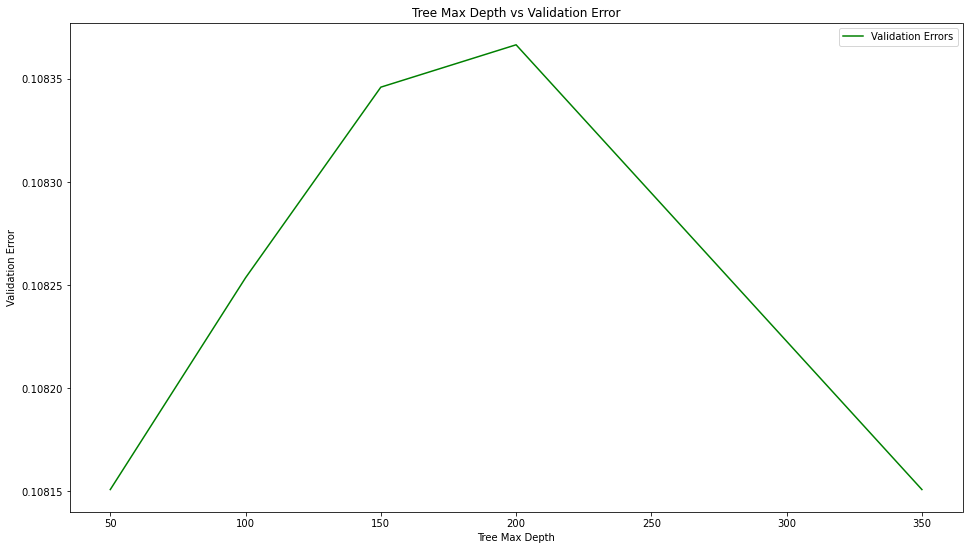

In [11]:
plt.figure(figsize=(16,9))
plt.plot(max_depths,val_errors, 'g-', label='Validation Errors')
plt.xlabel('Tree Max Depth')
plt.ylabel('Validation Error')
plt.title('Tree Max Depth vs Validation Error')
plt.legend()
plt.show()

Evaluating the tuned model on the test data.

In [12]:
# clf = load('fit-models/random-forest.joblib')
rf_metrics = mymetrics.get_metrics(models[0], x_test_s, y_test_s, 'Final RF')
mymetrics.print_metrics(rf_metrics)

Name: Final RF
cm: 



actual,0,1
pred,,
0,157423,19870
1,2804,28618


'\n'

Specificity: 

0.9824998283685021 

Sensitivity: 

0.5902078864873783 

Precision: 

0.9107631595697282 

Accuracy: 

0.8913638214790504 



In [16]:
dump(models[0], 'fit-models/random-forest.joblib')

['fit-models/random-forest.joblib']

Memory Issues with
RBF Net
Kernel PCA


<a id="ada"></a>
## AdaBoost

Creating a list named `eta` of possible learning rates.

In [13]:
eta = np.arange(0.1,1.5,step=.2)

Empty lists to store the various models and their validation errors. I'll be observing the validation error of models trained with the different learning rates defined above.

In [14]:
ada_models = []
ada_val_errors = []

Using cross-validation to determine the best learning rate. I'm observing the error produced from models trained with different learning rates to find the best learning rate for this data. 

In [16]:
starttime = time.time()
for e in eta:
    ada = AdaBoost(learning_rate=e, random_state=10)
    ada.fit(x_train_s.values, y_train_s.values.ravel())
    ada_models.append(ada)
    ada_val_errors.append(1 - ada.score(x_val_s.values, y_val_s.values.ravel()))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 174.4853196144104 seconds


Plotting the learning rates vs the errors produced from evaluating the model on the validation data. From the error values I used above it looks like 1.3 produces the lowest validation error.

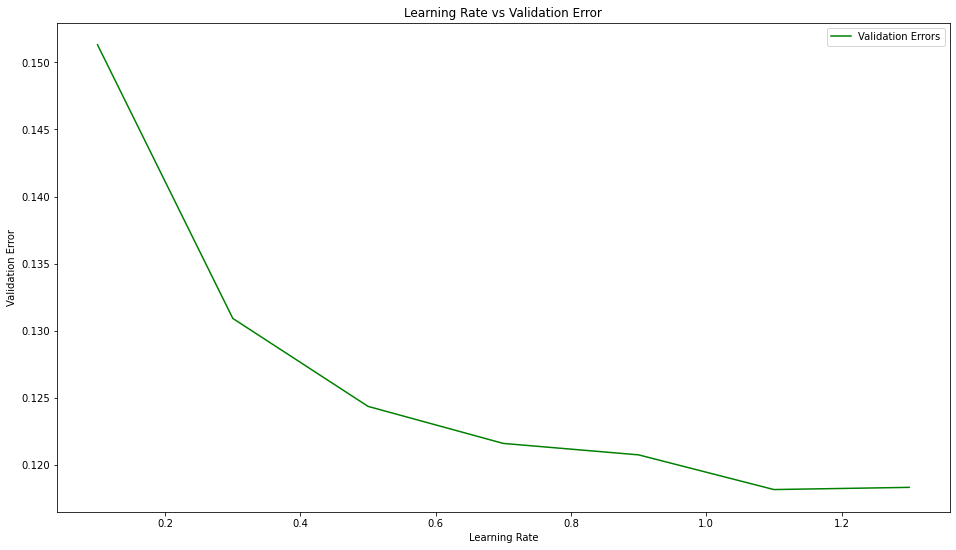

In [17]:
plt.figure(figsize=(16,9))
plt.plot(eta,ada_val_errors, 'g-', label='Validation Errors')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Error')
plt.title('Learning Rate vs Validation Error')
plt.legend()
plt.show()

Getting the model built with a learning rate of 1.1

In [18]:
idx = np.argmin(ada_val_errors)
ada = ada_models[idx]

The learning rate used that produced the lowest validation error is 1.1

In [19]:
eta[idx]

1.1000000000000003

Evaluating the AdaBoost model, trained with a learning rate of 1.1, on the test data.

In [20]:
mymetrics.print_metrics(mymetrics.get_metrics(ada, x_test_s, y_test_s, 'Learning Rate Tuned AdaBoost'))

Name: Learning Rate Tuned AdaBoost
Cost Matrix: 



actual,0,1
pred,,
0,156112,20684
1,4115,27804


Specificity: 

0.9743176867818782 

Sensitivity: 

0.5734202276852005 

Precision: 

0.8710799210501582 

Accuracy: 

0.8811824737081666 



Tuning the number of max estimators used. The default value for max estimators is 50 so by increasing the value I could improve the performance and it could also increase the chance of overfitting. I'll choose the value for max estimators that produces the lowest validation error and evaluate that model against the test data. I can then compare the results with those listed just above as the results above are from a model built with the default value for max estimators, 50. 

In [22]:
n_estimators = [100,200,500,1000,2000]
models = []
val_errors = []
starttime = time.time()
for n in n_estimators:
    ada = AdaBoost(learning_rate=1.1, random_state=10, n_estimators=n)
    ada.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(ada)
    val_errors.append(1 - ada.score(x_val_s.values, y_val_s.values.ravel()))
print('Training took:', time.time() - starttime, 'seconds')

Training took: 1853.7832219600677 seconds


Plotting the values used for the number of max estimators against the validation errors. 

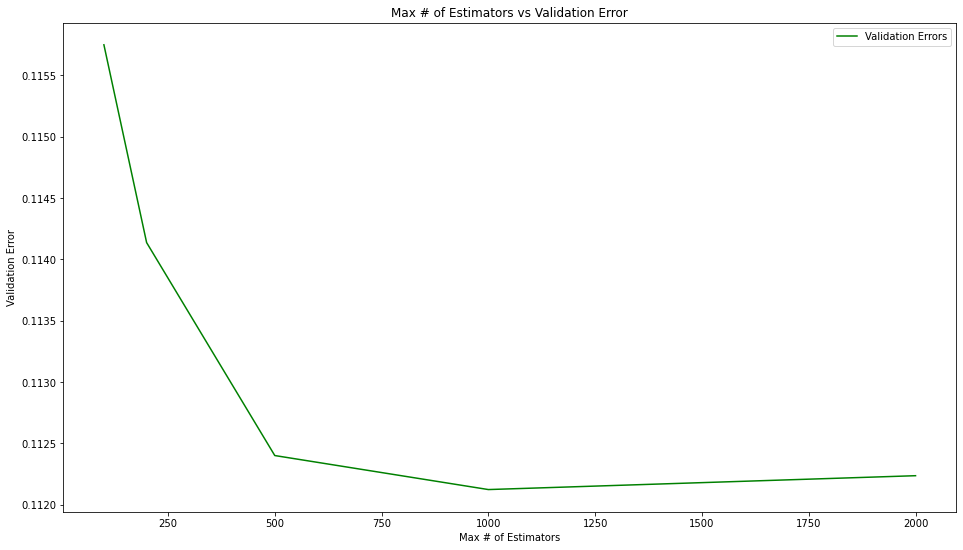

In [23]:
plt.figure(figsize=(16,9))
plt.plot(n_estimators,val_errors, 'g-', label='Validation Errors')
plt.xlabel('Max # of Estimators')
plt.ylabel('Validation Error')
plt.title('Max # of Estimators vs Validation Error')
plt.legend()
plt.show()

Based on the plot above I'm selecting the model that had 1000 for the max number of estimators and evaluating it against the test data. Below I show the metrics produced from evaluating the model on the test data.

In [24]:
ada = models[3]
mymetrics.print_metrics(mymetrics.get_metrics(ada, x_test_s, y_test_s, 'Learning Rate Tuned AdaBoost'))

Name: Learning Rate Tuned AdaBoost
Cost Matrix: 



actual,0,1
pred,,
0,156018,19350
1,4209,29138


Specificity: 

0.9737310191166283 

Sensitivity: 

0.6009321894076886 

Precision: 

0.873781749482712 

Accuracy: 

0.8871235895838824 



The model didn't perform better than the one built with a max number of estimators at the default of 50. It produced a better accuracy but smaller specificity, this is likely due to overfitting from allowing too many estimators. I'm going to use the default value, 50, for the max number of estimators.

In [26]:
ada = ada_models[5]
ada_metrics = mymetrics.get_metrics(ada, x_test_s, y_test_s, 'Final AdaBoost')
mymetrics.print_metrics(ada_metrics)

Name: Final AdaBoost
Cost Matrix: 



actual,0,1
pred,,
0,156112,20684
1,4115,27804


Specificity: 

0.9743176867818782 

Sensitivity: 

0.5734202276852005 

Precision: 

0.8710799210501582 

Accuracy: 

0.8811824737081666 



In [27]:
dump(ada, 'fit-models/adaboost.joblib')

['fit-models/adaboost.joblib']

Memory Issues with
RBF Net
Kernel PCA


<a id="svm"></a>
## Supprt Vector Machine

Below I use sklearn's LinearSVC 

In [8]:
starttime = time.time()
linear_svc = LinearSVC(dual=False, fit_intercept=False)
linear_svc.fit(x_train_s.values,y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 14.336856842041016 seconds


Evaluating the Linear SVC on the test data.

In [9]:
linear_svc_metrics = mymetrics.get_metrics(linear_svc, x_test_s, y_test_s, 'Fit Intercept False LinearSVC')
mymetrics.print_metrics(linear_svc_metrics)

Name: Fit Intercept False LinearSVC
Cost Matrix: 



actual,0,1
pred,,
0,159186,29720
1,1041,18768


Specificity: 

0.9935029676646258 

Sensitivity: 

0.387064840785349 

Precision: 

0.9474481296380434 

Accuracy: 

0.8526172052799271 



Testing the Linear SVC with `fit_intercept` as True. The fit_intercept argument determines whether or not to calculate the intercept for this model, if it's set to False then the data is expected to be centered.  

In [11]:
starttime = time.time()
svm_fit_intercept = LinearSVC(dual=False, fit_intercept=True)
svm_fit_intercept.fit(x_train_s.values,y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 15.622894763946533 seconds


In [12]:
fit_intercept_metrics = mymetrics.get_metrics(svm_fit_intercept, x_test_s, y_test_s, 'Fit Intercept False LinearSVC')
mymetrics.print_metrics(fit_intercept_metrics)

Name: Fit Intercept False LinearSVC
Cost Matrix: 



actual,0,1
pred,,
0,159185,29720
1,1042,18768


Specificity: 

0.9934967265192508 

Sensitivity: 

0.387064840785349 

Precision: 

0.9474003028773347 

Accuracy: 

0.8526124140574468 



When setting the `fit_intercept` argument to False the specificity was slightly higher for the test data. The data is scaled already.

In [14]:
dump(linear_svc, 'fit-models/linear-svc.joblib')

['fit-models/linear-svc.joblib']

### Testing the Kernel SVC from sklearn

Below I create a list of possible values for gamma.

In [11]:
Gamma = [0.01,0.1,1,10,15]

I'm evaluating which value for gamma will be best by building models with the different values of gamma, fitting them with the train data, and storing the validation error produced from each model when evaluated on the validation data.

In [13]:
models = []
val_errors = []
starttime = time.time()
for g in Gamma:
    svc = SVC(kernel="rbf", gamma=g, cache_size=6000, max_iter=2000)
    svc.fit(x_train_s, y_train_s.values.ravel())
    models.append(svc)
    val_errors.append(1 - svc.score(x_val_s.values, y_val_s.values.ravel()))
print('Training took:', time.time() - starttime, 'seconds')

/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your dat

Training took: 966.99236369133 seconds


Plotting gamma vs the validation error.

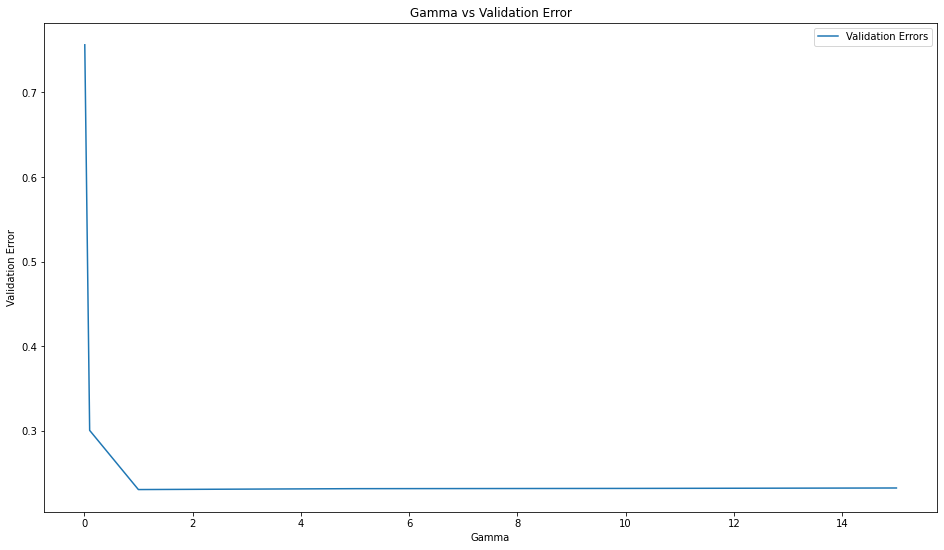

In [14]:
plt.figure(figsize=(16,9))
plt.plot(Gamma, val_errors, label='Validation Errors')
plt.xlabel('Gamma')
plt.ylabel('Validation Error')
plt.title('Gamma vs Validation Error')
plt.legend()
plt.show()

Kernel SVC Ran very slowly, I had to increase the cache size to avoid a memory error and decrease the number of max iterations so that I could run the tests in a reasonable time. After attempting unsupervised dimensionality reduction such as K-means and Kernel PCA I know that the data does not respond well to non-linear transformations and isn't easily transformed to a linearly separable space. It appears with 2000 max iterations none and for all the used values of gamma the training did not converge.

Based on the plot above I observe that when gamma is greater than 1 the validation error doesn't imporve significantly. This observation leads me to select 1 for the hyperparameter gamma. I'm selecting the model that was built with gamma=1 below.

In [15]:
ksvc = models[2]

Evaluating the Kernel SVC on the test data and displaying the confusion matrix and metrics below.

In [16]:
ksvc_metrics = mymetrics.get_metrics(ksvc, x_test_s, y_test_s, 'Kernel SVC')
mymetrics.print_metrics(ksvc_metrics)

Name: Kernel SVC
Cost Matrix: 



actual,0,1
pred,,
0,159887,47959
1,340,529


Specificity: 

0.9978780105725003 

Sensitivity: 

0.010909915855469394 

Precision: 

0.6087456846950517 

Accuracy: 

0.7685887454183935 



The results above show that the model did well at not incorrectly predicting a death when the animal lives and has a really high specificity but on the other hand the model captured realtively few actual deaths and predicted mostly "Finish" or 0, meaning the animal lives.

Saving the fit Kernel SVC to disk.

In [18]:
dump(ksvc,'fit-models/kernel-svc.joblib')

['fit-models/kernel-svc.joblib']

<a id="lr"></a>
## Logistic Regression

Below I'm using the Logistic Regression (LR) class from sklearn. I instantiate the LR model with an extension of Stochastic Average Gradient descent (saga) for the optimizer. The saga optimizer is supposed to generally train faster than standard Stochastic Average Gradient descent and work well with very large datasets. I'm setting the `multi_class` to one-vs.-rest so that I can run the training in parallel with the argument `n_jobs`. I've also set the argument `dual` to False because in the API documentation for sklearn it is advised to set it to False if the number of samples is greater than the number of features. With the default value for max iterations at 100 the training did not converge so I upped the max iterations argument `max_iters` to 1000.

In [25]:
starttime = time.time()
lr = LR(max_iter=1000, solver='saga', multi_class='ovr', n_jobs=6, random_state=10, dual=False)
lr.fit(x_train_s.values, y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 310.2446074485779 seconds


/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [27]:
L2_lr_metrics = mymetrics.get_metrics(lr, x_val_s, y_val_s, 'L2 Penalty Logistic Regression')
mymetrics.print_metrics(L2_lr_metrics)

Name: L2 Penalty Logistic Regression
Cost Matrix: 



actual,0,1
pred,,
0,73630,12735
1,1250,9786


Specificity: 

0.9833066239316239 

Sensitivity: 

0.43452777407752763 

Precision: 

0.8867343240304458 

Accuracy: 

0.8564183119269823 



Since I'm using the `saga` solver I've decided to compare the performance on the validation set when a `l2` and `elasticnet` solver is used. `l2` was used in the model trained and evaluated above. By setting the `l_ratio` argument to a value between 0 and 1.  ($0 <$ `l1_ratio` $< 1$) the l1 and l2 penalties are used in combination. the `elasticnet` penalty is only supported with a `saga` solver and setting `l1_ratio` to 0 is the same as using a `l2` penalty and setting the ratio to 1 is equivalent to useing a `l1` penalty.

In [29]:
starttime = time.time()
lr = LR(max_iter=1000, solver='saga', multi_class='ovr', n_jobs=6, random_state=10, dual=False, penalty='elasticnet', l1_ratio=.5)
lr.fit(x_train_s.values, y_train_s.values.ravel())
print('Training took:', time.time() - starttime, 'seconds')

Training took: 382.25754952430725 seconds


/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Evaluating the logistic regression model, trained with an `elasticnet` penalty, on the validation data.

In [30]:
elasticnet_metrics = mymetrics.get_metrics(lr, x_val_s, y_val_s, 'Elasticnet Penalty Logistic Regression')
mymetrics.print_metrics(elasticnet_metrics)

Name: Elasticnet Penalty Logistic Regression
Cost Matrix: 



actual,0,1
pred,,
0,73630,12738
1,1250,9783


Specificity: 

0.9833066239316239 

Sensitivity: 

0.4343945650725989 

Precision: 

0.8867035257862775 

Accuracy: 

0.856387511421854 



Based on the results above the logistic regression model trained with an 'elasticnet' penalty peformed slightly worse in terms of accuracy than that of the model trained with an 'l2' penalty and the 'elasticnet' model took longer to train.

I'm going to compare different strenghths of regularization to see if I can get better performance.

In [31]:
C = [0.1, 0.5, 2, 5]
models = []
metrics = []
starttime = time.time()
for c in C:
    lr = LR(max_iter=1000, solver='saga', multi_class='ovr', n_jobs=6, random_state=10, dual=False, C=c)
    lr.fit(x_train_s.values, y_train_s.values.ravel())
    models.append(lr)
    metrics.append(mymetrics.get_metrics(lr, x_val_s, y_val_s, 'Regularization C=' + str(c)))
print('Training took:', time.time() - starttime, 'seconds')

/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Training took: 1256.1523294448853 seconds


/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Below I'm storing the validation errors and specificities for the 4 models trained above so I can plot them against the value used for the regularization term C.

In [37]:
val_errors = []
specificities = []
for m in metrics:
    val_errors.append(1 - m['Accuracy'])
    specificities.append(m['Specificity'])

Plotting the regularization term C against the validation error produced from each model.

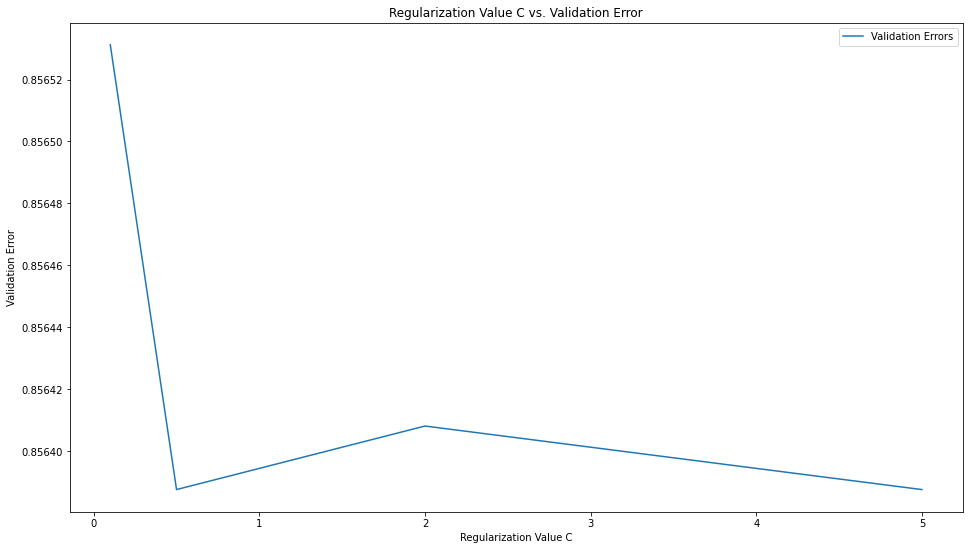

In [45]:
plt.figure(figsize=(16,9))
plt.plot(C, accuracies, label='Validation Errors')
plt.xlabel('Regularization Value C')
plt.ylabel('Validation Error')
plt.title('Regularization Value C vs. Validation Error')
plt.legend()
plt.show()

Below I plot the regularization value C against it's respective specificity. Based on the plot above and the plot below using a higher value for regularization, in this case 5, I produce a lower validation error and higher specificity. By using 5 for the regulariztion term I'm decreasing the strength of regularization.

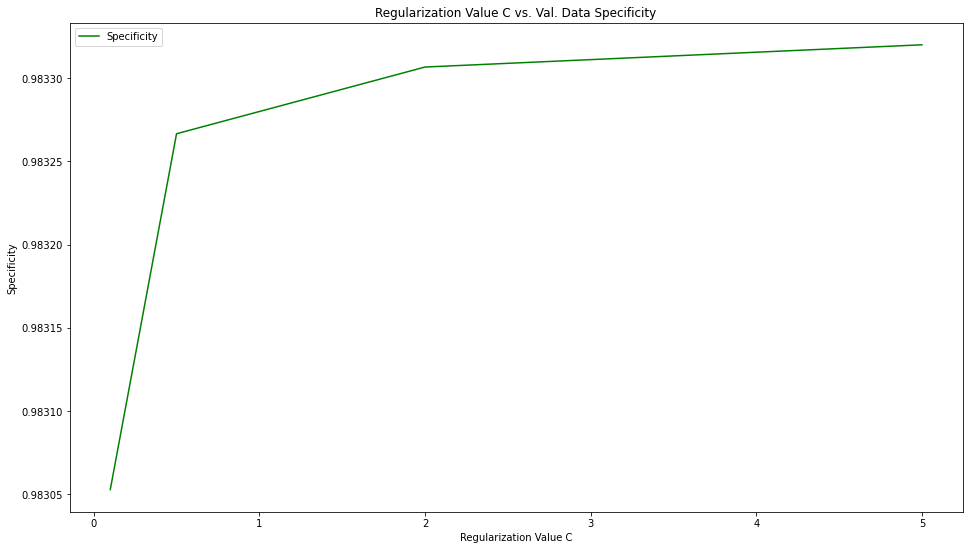

In [44]:
plt.figure(figsize=(16,9))
plt.plot(C, specificities, 'g', label='Specificity')
plt.xlabel('Regularization Value C')
plt.ylabel('Specificity')
plt.title('Regularization Value C vs. Val. Data Specificity')
plt.legend()
plt.show()

Below I take the model that was trained with a regularization term of 5 and evaluate it on the test data. The results in form a of the confusion matrix and metrics are displayed below.

In [49]:
lr = models[3]
lr_metrics = mymetrics.get_metrics(lr, x_test_s, y_test_s, 'Final/Tuned Logistic Regression')
mymetrics.print_metrics(lr_metrics)

Name: Final/Tuned Logistic Regression
Cost Matrix: 



actual,0,1
pred,,
0,157611,27449
1,2616,21039


Specificity: 

0.983673163699002 

Sensitivity: 

0.4339011714238574 

Precision: 

0.8894102726696259 

Accuracy: 

0.8559518961262966 



Saving the tuned logistic regression model to disk. 

In [51]:
dump(lr,'fit-models/logistic-regression.joblib')

['fit-models/logistic-regression.joblib']

<a id="nn"></a>
## Neural Network

Below I'm using TensorFlow to build a neural network. 
I'm using the normalized dataset instead of the standardizing data because neural nets assume no distribution. The normalized data should help speed up the training process also. I'm creating tensor datasets with tensorflow's API for the train, validation, and test data. Using tensors allow me to take advantage of TensorFlows Hardware acceleration support and reduce the training and prediciting time.

In [108]:
dataset_train = tf.data.Dataset.from_tensors((x_train_n, y_train_n))
dataset_val = tf.data.Dataset.from_tensors((x_val_n, y_val_n))
dataset_tets = tf.data.Dataset.from_tensors((x_test_n, y_test_n))
dataset_train.shuffle(5000)

<ShuffleDataset shapes: ((361772, 71), (361772, 1)), types: (tf.float64, tf.int64)>

I'm using TensorFlow's Functional API to construct the neural net model below. I'm starting off only one hidden layer. I've also added a dropout layer to help combat overfitting. The dropout layer is passed the float .30 representing the fraction of input units to drop in each forward-pass. The hidden layer has 16 nodes that are using the ReLu activation function. I've selected ReLu to help reduce the chance of vanishing gradients. The output layer has a single node and uses a sigmoid activation function as this is for binary classification. When compiling the model I set the optimizer to use the Adam algorithm and the learning rate to 0.01. The loss function used below is Binary Crossenropy and the model tracks the accuracy, precision, and recall. 

In [53]:
def build_model():
    
    inputs = tf.keras.Input(shape=(x_train_n.shape[1]))
    dense_layer1 = keras.layers.Dense(16, activation=tf.nn.relu)
    x = dense_layer1(inputs)
    dropout_layer = keras.layers.Dropout(0.3)
    x = dropout_layer(x)
    predictions_layer = keras.layers.Dense(1, activation=tf.nn.sigmoid)
    predictions = predictions_layer(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(0.7),
                           tf.keras.metrics.Recall(0.7)
                          ])
    return model

Below I instantiate the model by calling the function `build_model()` which compiles the configuration as described above. A summary of the model is displayed below.

In [54]:
model = build_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


I'm also display a graph that represents the model built above. We can see that the input layer takes any number of examples with 71 features. The input layer feeds into the hidden layer that takes the number of features from 71 to 16 as there are 16 nodes in that layer. The dropout layer removes input units and then feeds the output layer with takes examples with 16 features and outputs a single value, the prediction.

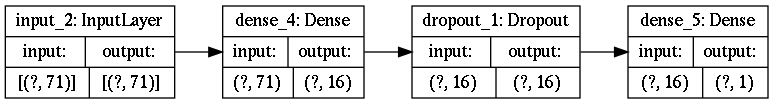

In [55]:
keras.utils.plot_model(model, "Neural_Net_1.png", show_shapes=True,rankdir='LR')

I'm setting the number of epochs for training to 1000. I create a tensor of tensor type int64 to store the value.

In [110]:
num_epochs = tf.Variable(1000, dtype=tf.int64)
num_epochs

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=1000>

I have an Nvidia graphics card and have set up my machine so I can take advantage of TensorFlow's GPU support (hardware accleration). If you do not have GPU support, comment out line 1 and untab lines 2 and 3.

I pass in the train data and the number of epochs to the fit function. The fit function also takes the validation dataset and evaluates the model on it and checks the loss value and metric values after each epoch. The validation data is not used in training.

In [17]:
with tf.device('/gpu:0'):
    tf.keras.backend.clear_session()
    training_history = model.fit(dataset_train, epochs=num_epochs.value(), validation_data=dataset_val)

Epoch 1/1000
1/1 [==============================] - 0s 341ms/step - loss: 0.7615 - accuracy: 0.3903 - precision_2: 0.1785 - recall_2: 0.0195 - val_loss: 0.6784 - val_accuracy: 0.5813 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.6863 - accuracy: 0.5501 - precision_2: 0.1723 - recall_2: 0.0014 - val_loss: 0.6216 - val_accuracy: 0.7331 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.6302 - accuracy: 0.6810 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.5819 - val_accuracy: 0.7675 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.5916 - accuracy: 0.7418 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.5574 - val_accuracy: 0.7685 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/1000
1/1 [=========

1/1 [==============================] - 0s 47ms/step - loss: 0.4768 - accuracy: 0.7730 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.4626 - val_accuracy: 0.7732 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 68/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.4751 - accuracy: 0.7742 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.4614 - val_accuracy: 0.7748 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 69/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.4740 - accuracy: 0.7756 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.4602 - val_accuracy: 0.7760 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 70/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.4725 - accuracy: 0.7773 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.4591 - val_accuracy: 0.7772 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 71/1000
1/1 [===

1/1 [==============================] - 0s 48ms/step - loss: 0.4291 - accuracy: 0.8494 - precision_2: 0.9999 - recall_2: 0.2499 - val_loss: 0.4079 - val_accuracy: 0.8528 - val_precision_2: 1.0000 - val_recall_2: 0.3507
Epoch 136/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.4282 - accuracy: 0.8492 - precision_2: 0.9998 - recall_2: 0.2499 - val_loss: 0.4072 - val_accuracy: 0.8528 - val_precision_2: 1.0000 - val_recall_2: 0.3516
Epoch 137/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4280 - accuracy: 0.8495 - precision_2: 0.9999 - recall_2: 0.2522 - val_loss: 0.4066 - val_accuracy: 0.8528 - val_precision_2: 1.0000 - val_recall_2: 0.3521
Epoch 138/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.4275 - accuracy: 0.8491 - precision_2: 0.9999 - recall_2: 0.2535 - val_loss: 0.4059 - val_accuracy: 0.8528 - val_precision_2: 0.9999 - val_recall_2: 0.3529
Epoch 139/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4270 -

1/1 [==============================] - 0s 37ms/step - loss: 0.3983 - accuracy: 0.8505 - precision_2: 0.9987 - recall_2: 0.3420 - val_loss: 0.3802 - val_accuracy: 0.8528 - val_precision_2: 0.9988 - val_recall_2: 0.3646
Epoch 206/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.3982 - accuracy: 0.8507 - precision_2: 0.9988 - recall_2: 0.3424 - val_loss: 0.3801 - val_accuracy: 0.8528 - val_precision_2: 0.9983 - val_recall_2: 0.3646
Epoch 207/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3981 - accuracy: 0.8505 - precision_2: 0.9987 - recall_2: 0.3427 - val_loss: 0.3800 - val_accuracy: 0.8528 - val_precision_2: 0.9984 - val_recall_2: 0.3646
Epoch 208/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3981 - accuracy: 0.8506 - precision_2: 0.9987 - recall_2: 0.3431 - val_loss: 0.3799 - val_accuracy: 0.8528 - val_precision_2: 0.9986 - val_recall_2: 0.3646
Epoch 209/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3978 -

1/1 [==============================] - 0s 36ms/step - loss: 0.3908 - accuracy: 0.8502 - precision_2: 0.9980 - recall_2: 0.3492 - val_loss: 0.3750 - val_accuracy: 0.8528 - val_precision_2: 0.9973 - val_recall_2: 0.3652
Epoch 276/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3907 - accuracy: 0.8500 - precision_2: 0.9977 - recall_2: 0.3482 - val_loss: 0.3750 - val_accuracy: 0.8528 - val_precision_2: 0.9973 - val_recall_2: 0.3652
Epoch 277/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.3912 - accuracy: 0.8500 - precision_2: 0.9976 - recall_2: 0.3482 - val_loss: 0.3748 - val_accuracy: 0.8528 - val_precision_2: 0.9971 - val_recall_2: 0.3652
Epoch 278/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3906 - accuracy: 0.8502 - precision_2: 0.9976 - recall_2: 0.3489 - val_loss: 0.3748 - val_accuracy: 0.8529 - val_precision_2: 0.9973 - val_recall_2: 0.3652
Epoch 279/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3906 -

1/1 [==============================] - 0s 31ms/step - loss: 0.3853 - accuracy: 0.8504 - precision_2: 0.9972 - recall_2: 0.3506 - val_loss: 0.3715 - val_accuracy: 0.8529 - val_precision_2: 0.9971 - val_recall_2: 0.3657
Epoch 346/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.3854 - accuracy: 0.8506 - precision_2: 0.9969 - recall_2: 0.3515 - val_loss: 0.3715 - val_accuracy: 0.8530 - val_precision_2: 0.9971 - val_recall_2: 0.3656
Epoch 347/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.3854 - accuracy: 0.8504 - precision_2: 0.9967 - recall_2: 0.3513 - val_loss: 0.3715 - val_accuracy: 0.8530 - val_precision_2: 0.9971 - val_recall_2: 0.3656
Epoch 348/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3852 - accuracy: 0.8505 - precision_2: 0.9968 - recall_2: 0.3513 - val_loss: 0.3715 - val_accuracy: 0.8529 - val_precision_2: 0.9971 - val_recall_2: 0.3657
Epoch 349/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.3853 -

1/1 [==============================] - 0s 32ms/step - loss: 0.3804 - accuracy: 0.8509 - precision_2: 0.9962 - recall_2: 0.3553 - val_loss: 0.3683 - val_accuracy: 0.8531 - val_precision_2: 0.9962 - val_recall_2: 0.3660
Epoch 416/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3803 - accuracy: 0.8508 - precision_2: 0.9958 - recall_2: 0.3557 - val_loss: 0.3683 - val_accuracy: 0.8531 - val_precision_2: 0.9962 - val_recall_2: 0.3660
Epoch 417/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3803 - accuracy: 0.8509 - precision_2: 0.9964 - recall_2: 0.3554 - val_loss: 0.3683 - val_accuracy: 0.8531 - val_precision_2: 0.9964 - val_recall_2: 0.3658
Epoch 418/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.3799 - accuracy: 0.8507 - precision_2: 0.9961 - recall_2: 0.3551 - val_loss: 0.3683 - val_accuracy: 0.8531 - val_precision_2: 0.9962 - val_recall_2: 0.3660
Epoch 419/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3804 -

1/1 [==============================] - 0s 35ms/step - loss: 0.3758 - accuracy: 0.8513 - precision_2: 0.9957 - recall_2: 0.3573 - val_loss: 0.3653 - val_accuracy: 0.8534 - val_precision_2: 0.9960 - val_recall_2: 0.3665
Epoch 486/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3760 - accuracy: 0.8513 - precision_2: 0.9952 - recall_2: 0.3570 - val_loss: 0.3653 - val_accuracy: 0.8534 - val_precision_2: 0.9960 - val_recall_2: 0.3664
Epoch 487/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3756 - accuracy: 0.8513 - precision_2: 0.9952 - recall_2: 0.3565 - val_loss: 0.3653 - val_accuracy: 0.8533 - val_precision_2: 0.9960 - val_recall_2: 0.3664
Epoch 488/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3755 - accuracy: 0.8513 - precision_2: 0.9959 - recall_2: 0.3565 - val_loss: 0.3652 - val_accuracy: 0.8534 - val_precision_2: 0.9957 - val_recall_2: 0.3665
Epoch 489/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3757 -

1/1 [==============================] - 0s 49ms/step - loss: 0.3726 - accuracy: 0.8513 - precision_2: 0.9952 - recall_2: 0.3577 - val_loss: 0.3627 - val_accuracy: 0.8538 - val_precision_2: 0.9951 - val_recall_2: 0.3668
Epoch 556/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3722 - accuracy: 0.8517 - precision_2: 0.9946 - recall_2: 0.3582 - val_loss: 0.3625 - val_accuracy: 0.8535 - val_precision_2: 0.9952 - val_recall_2: 0.3667
Epoch 557/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3724 - accuracy: 0.8515 - precision_2: 0.9946 - recall_2: 0.3581 - val_loss: 0.3625 - val_accuracy: 0.8539 - val_precision_2: 0.9951 - val_recall_2: 0.3668
Epoch 558/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.3717 - accuracy: 0.8517 - precision_2: 0.9949 - recall_2: 0.3588 - val_loss: 0.3623 - val_accuracy: 0.8538 - val_precision_2: 0.9951 - val_recall_2: 0.3667
Epoch 559/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3722 -

1/1 [==============================] - 0s 48ms/step - loss: 0.3689 - accuracy: 0.8519 - precision_2: 0.9938 - recall_2: 0.3589 - val_loss: 0.3596 - val_accuracy: 0.8541 - val_precision_2: 0.9949 - val_recall_2: 0.3668
Epoch 626/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3691 - accuracy: 0.8519 - precision_2: 0.9945 - recall_2: 0.3587 - val_loss: 0.3598 - val_accuracy: 0.8543 - val_precision_2: 0.9947 - val_recall_2: 0.3669
Epoch 627/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3692 - accuracy: 0.8523 - precision_2: 0.9940 - recall_2: 0.3591 - val_loss: 0.3598 - val_accuracy: 0.8539 - val_precision_2: 0.9952 - val_recall_2: 0.3668
Epoch 628/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3690 - accuracy: 0.8515 - precision_2: 0.9947 - recall_2: 0.3585 - val_loss: 0.3599 - val_accuracy: 0.8542 - val_precision_2: 0.9947 - val_recall_2: 0.3669
Epoch 629/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.3691 -

1/1 [==============================] - 0s 38ms/step - loss: 0.3668 - accuracy: 0.8524 - precision_2: 0.9920 - recall_2: 0.3597 - val_loss: 0.3572 - val_accuracy: 0.8543 - val_precision_2: 0.9944 - val_recall_2: 0.3671
Epoch 696/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3662 - accuracy: 0.8523 - precision_2: 0.9932 - recall_2: 0.3597 - val_loss: 0.3571 - val_accuracy: 0.8547 - val_precision_2: 0.9939 - val_recall_2: 0.3673
Epoch 697/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.3662 - accuracy: 0.8526 - precision_2: 0.9928 - recall_2: 0.3598 - val_loss: 0.3568 - val_accuracy: 0.8545 - val_precision_2: 0.9941 - val_recall_2: 0.3671
Epoch 698/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3664 - accuracy: 0.8523 - precision_2: 0.9930 - recall_2: 0.3595 - val_loss: 0.3567 - val_accuracy: 0.8547 - val_precision_2: 0.9939 - val_recall_2: 0.3673
Epoch 699/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.3661 -

1/1 [==============================] - 0s 32ms/step - loss: 0.3638 - accuracy: 0.8527 - precision_2: 0.9929 - recall_2: 0.3602 - val_loss: 0.3542 - val_accuracy: 0.8548 - val_precision_2: 0.9937 - val_recall_2: 0.3674
Epoch 766/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3637 - accuracy: 0.8528 - precision_2: 0.9922 - recall_2: 0.3605 - val_loss: 0.3543 - val_accuracy: 0.8548 - val_precision_2: 0.9935 - val_recall_2: 0.3675
Epoch 767/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3634 - accuracy: 0.8529 - precision_2: 0.9927 - recall_2: 0.3604 - val_loss: 0.3542 - val_accuracy: 0.8547 - val_precision_2: 0.9939 - val_recall_2: 0.3674
Epoch 768/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3636 - accuracy: 0.8526 - precision_2: 0.9931 - recall_2: 0.3600 - val_loss: 0.3541 - val_accuracy: 0.8553 - val_precision_2: 0.9934 - val_recall_2: 0.3676
Epoch 769/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3633 -

1/1 [==============================] - 0s 35ms/step - loss: 0.3614 - accuracy: 0.8531 - precision_2: 0.9916 - recall_2: 0.3610 - val_loss: 0.3517 - val_accuracy: 0.8555 - val_precision_2: 0.9930 - val_recall_2: 0.3676
Epoch 836/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3610 - accuracy: 0.8535 - precision_2: 0.9926 - recall_2: 0.3614 - val_loss: 0.3516 - val_accuracy: 0.8557 - val_precision_2: 0.9930 - val_recall_2: 0.3676
Epoch 837/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.3612 - accuracy: 0.8533 - precision_2: 0.9925 - recall_2: 0.3614 - val_loss: 0.3515 - val_accuracy: 0.8556 - val_precision_2: 0.9930 - val_recall_2: 0.3676
Epoch 838/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3611 - accuracy: 0.8534 - precision_2: 0.9925 - recall_2: 0.3613 - val_loss: 0.3515 - val_accuracy: 0.8558 - val_precision_2: 0.9930 - val_recall_2: 0.3676
Epoch 839/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.3610 -

1/1 [==============================] - 0s 37ms/step - loss: 0.3600 - accuracy: 0.8541 - precision_2: 0.9900 - recall_2: 0.3637 - val_loss: 0.3503 - val_accuracy: 0.8554 - val_precision_2: 0.9934 - val_recall_2: 0.3676
Epoch 906/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3599 - accuracy: 0.8534 - precision_2: 0.9929 - recall_2: 0.3609 - val_loss: 0.3498 - val_accuracy: 0.8568 - val_precision_2: 0.9924 - val_recall_2: 0.3680
Epoch 907/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.3594 - accuracy: 0.8539 - precision_2: 0.9908 - recall_2: 0.3630 - val_loss: 0.3494 - val_accuracy: 0.8562 - val_precision_2: 0.9927 - val_recall_2: 0.3678
Epoch 908/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3592 - accuracy: 0.8532 - precision_2: 0.9913 - recall_2: 0.3615 - val_loss: 0.3493 - val_accuracy: 0.8562 - val_precision_2: 0.9927 - val_recall_2: 0.3679
Epoch 909/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.3591 -

1/1 [==============================] - 0s 39ms/step - loss: 0.3577 - accuracy: 0.8537 - precision_2: 0.9923 - recall_2: 0.3614 - val_loss: 0.3475 - val_accuracy: 0.8575 - val_precision_2: 0.9925 - val_recall_2: 0.3683
Epoch 976/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3575 - accuracy: 0.8546 - precision_2: 0.9907 - recall_2: 0.3641 - val_loss: 0.3473 - val_accuracy: 0.8565 - val_precision_2: 0.9930 - val_recall_2: 0.3679
Epoch 977/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.3571 - accuracy: 0.8541 - precision_2: 0.9917 - recall_2: 0.3619 - val_loss: 0.3471 - val_accuracy: 0.8572 - val_precision_2: 0.9925 - val_recall_2: 0.3681
Epoch 978/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.3568 - accuracy: 0.8547 - precision_2: 0.9901 - recall_2: 0.3635 - val_loss: 0.3470 - val_accuracy: 0.8567 - val_precision_2: 0.9928 - val_recall_2: 0.3680
Epoch 979/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.3573 -

In [18]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2'])

Below I plot the Accuracy and Loss against the number of epochs on the left and the Precision and Recall against the number of epochs on the right. Based on the two graphs below I can use less epochs to shorten the training time and still achieve convergence. I'll try 800 epochs.

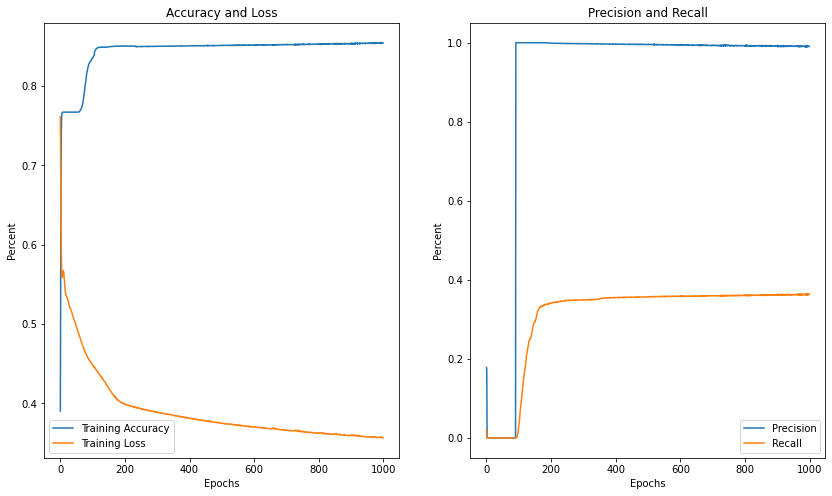

In [19]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']

precision = training_history.history['precision_2']
recall = training_history.history['recall_2']

epochs_range = range(num_epochs.value())

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, train_loss, label='Training Loss')

plt.title('Accuracy and Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs_range, precision, label='Precision')
plt.plot(epochs_range, recall, label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.title('Precision and Recall')
plt.legend()

Below I evaluate the model on the validation model and also demonstrate the performance increase when using a tensor dataset as opposed to numpy arrays. In the first evaluation I use numpy arrays and process the evaluation on the GPU. The second evaluation I use a tensor dataset on the GPU, and in the third I use a tensor dataset on the CPU. We can see that using a tensor dataset on the GPU yields by far the quickest processing.

Demonstrating time performance with numpy arrays using the GPU.

In [24]:
with tf.device('/gpu:0'):
    score = model.evaluate(x_val_n, y_val_n)
    score_df = pd.Series(score, index = model.metrics_names)

score_df

2827/2827 [==============================] - 4s 1ms/step - loss: 0.3464 - accuracy: 0.8567 - precision_2: 0.9930 - recall_2: 0.3681


loss           0.346449
accuracy       0.856727
precision_2    0.993041
recall_2       0.368092
dtype: float64

Demonstrating time performance with a tensor dataset using the GPU.

In [27]:
with tf.device('/gpu:0'):
    score = model.evaluate(dataset_val)
    score_df = pd.Series(score, index = model.metrics_names)

score_df

1/1 [==============================] - 0s 1ms/step - loss: 0.3464 - accuracy: 0.8567 - precision_2: 0.9930 - recall_2: 0.3681


loss           0.346449
accuracy       0.856727
precision_2    0.993041
recall_2       0.368092
dtype: float64

Demonstrating time performance with a tensor dataset on the CPU.

In [28]:
with tf.device('/cpu:0'):
    score = model.evaluate(dataset_val)
    score_df = pd.Series(score, index = model.metrics_names)

score_df

1/1 [==============================] - 0s 6ms/step - loss: 0.3464 - accuracy: 0.8567 - precision_2: 0.9930 - recall_2: 0.3681


loss           0.346449
accuracy       0.856727
precision_2    0.993041
recall_2       0.368092
dtype: float64

Below I store the predictions on the validation data and use a threshold of 0.7 to determine whether the prediciton is 1 or 0. Predictions greater than or equal to 0.7 are 1 and less than or equal to 0.7 are 0. This is effectively a weighted cost matrix and putting a higher weight on mispredicted positive cases. By doing so I minimize the false positive rate and maximize the specificity.

In [34]:
y_pred = model.predict(x_val_n)
y_pred = np.where(y_pred>=0.7, 1, y_pred)
y_pred = np.where(y_pred<0.7, 0, y_pred)
pred_results = pd.DataFrame({'y_test': y_val_n.values.flatten().astype('int32'),
                             'y_pred': y_pred.flatten().astype('int32') }, index = range(len(y_pred)))

Displaying the confusion matrix and metric values from evaluating the neural net with one hidden layer on the validation data below.

In [36]:
cm = pd.crosstab(pred_results.y_pred, pred_results.y_test)
cm

y_test,0,1
y_pred,,
0,69454,13229
1,54,7706


Metric Values for the neural net with 1 hidden layer.

In [37]:
metrics = {}
metrics['Name'] = "Neural Net 1 Hidden Layer"
metrics['CM'] = cm
metrics['Specificity'] = cm[0][0] / (cm[0][0]+cm[0][1])
metrics['Sensitivity'] = cm[1][1] / (cm[1][1] + cm[1][0])
metrics['Precision'] = cm[1][1] / (cm[1][1] + cm[0][1])
metrics['Accuracy'] = (cm[1][1] + cm[0][0]) / (cm[1][1]+cm[0][0]+cm[1][0]+cm[0][1])
for k,v in metrics.items():
        if k == 'Name':
            print(k + ':', v)
        elif k == 'CM':  
            print("Cost Matrix:",'\n')
            display(v)
        else:
            print(k + ':','\n')
            print(v, '\n')

Name: Neural Net 1 Hidden Layer
Cost Matrix: 



y_test,0,1
y_pred,,
0,69454,13229
1,54,7706


Specificity: 

0.9992231110088048 

Sensitivity: 

0.3680917124432768 

Precision: 

0.9930412371134021 

Accuracy: 

0.8531340181108543 



Below I add two more hidden layers and change the number of nodes in the hidden layers. The first hidden layer has 24 nodes, the second layer has 16, and the third hidden layer has 8 nodes. 

In [50]:
tf.keras.backend.clear_session()
def build_model():
    
    inputs = tf.keras.Input(shape=(x_train_n.shape[1]))
    dense_layer1 = keras.layers.Dense(24, activation=tf.nn.relu)
    x = dense_layer1(inputs)
    dense_layer2 = keras.layers.Dense(16, activation=tf.nn.relu)
    x = dense_layer2(x)
    dropout_layer = keras.layers.Dropout(0.3)
    x = dropout_layer(x)
    dense_layer3 = keras.layers.Dense(8, activation=tf.nn.relu)
    x = dense_layer3(x)
    predictions_layer = keras.layers.Dense(1, activation=tf.nn.sigmoid)
    predictions = predictions_layer(x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(0.7),
                           tf.keras.metrics.Recall(0.7)
                          ])
    return model

Compiling the model and viewing the summary.

In [51]:
model = build_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
dense (Dense)                (None, 24)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
___________________________________________________________

Displaying the graph of the larger neural network.

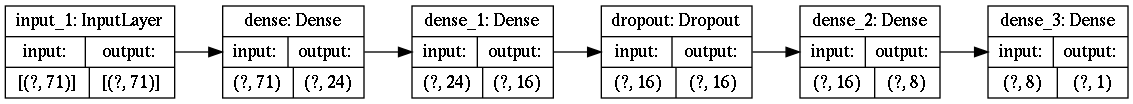

In [52]:
keras.utils.plot_model(model, "Neural_Net_2.png", show_shapes=True, rankdir='LR')

Training the larger neural network with the same train data, 1000 epochs, and the validation data. This time I set the `verbose` parameter to 0 so the epoch history isn't printed to screen. 

In [55]:
with tf.device('/gpu:0'):
    training_history = model.fit(dataset_train, epochs=num_epochs.value(), validation_data=dataset_val, verbose=0)

Again storing the predictions of the neural net on the validation data. This time the predictions are made from the network with 3 hidden layers.

In [56]:
y_pred = model.predict(x_val_n)
y_pred = np.where(y_pred>=0.7, 1, y_pred)
y_pred = np.where(y_pred<0.7, 0, y_pred)
pred_results = pd.DataFrame({'y_test': y_val_n.values.flatten().astype('int32'),
                             'y_pred': y_pred.flatten().astype('int32') }, index = range(len(y_pred)))

Printing the confusion matrix for the evalution on the validation data and the metrics calculated from the matrix.

In [90]:
cm = pd.crosstab(pred_results.y_pred, pred_results.y_test)

In [91]:
nn2_metrics = {}
nn2_metrics['Name'] = "Neural Net, 3 Hidden Layer"
nn2_metrics['CM'] = cm
nn2_metrics['Specificity'] = cm[0][0] / (cm[0][0]+cm[0][1])
nn2_metrics['Sensitivity'] = cm[1][1] / (cm[1][1] + cm[1][0])
nn2_metrics['Precision'] = cm[1][1] / (cm[1][1] + cm[0][1])
nn2_metrics['Accuracy'] = (cm[1][1] + cm[0][0]) / (cm[1][1]+cm[0][0]+cm[1][0]+cm[0][1])
for k,v in nn2_metrics.items():
        if k == 'Name':
            print(k + ':', v)
        elif k == 'CM':  
            print("Cost Matrix:",'\n')
            display(v)
        else:
            print(k + ':','\n')
            print(v, '\n')

Name: Neural Net, 3 Hidden Layer
Cost Matrix: 



y_test,0,1
y_pred,,
0,69491,13263
1,17,7672


Specificity: 

0.9997554238361052 

Sensitivity: 

0.36646763792691667 

Precision: 

0.9977890492911952 

Accuracy: 

0.8531671881737669 



The method `autolabel` below was modified from https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py so that I can display the values of each bar on the bar chart below. The metric values of the networks with 1 and 3 hidden layers were very close so displaying the actual value helps with interpreting the graph.

In [12]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

Below I plot the validation metrics from the neural networks built with 1 and 3 hidden layers. The larger network performed slightly better in specificity, precision, and accuracy. Because of these observations I'm going to use the larger network and evalute it on the test data.

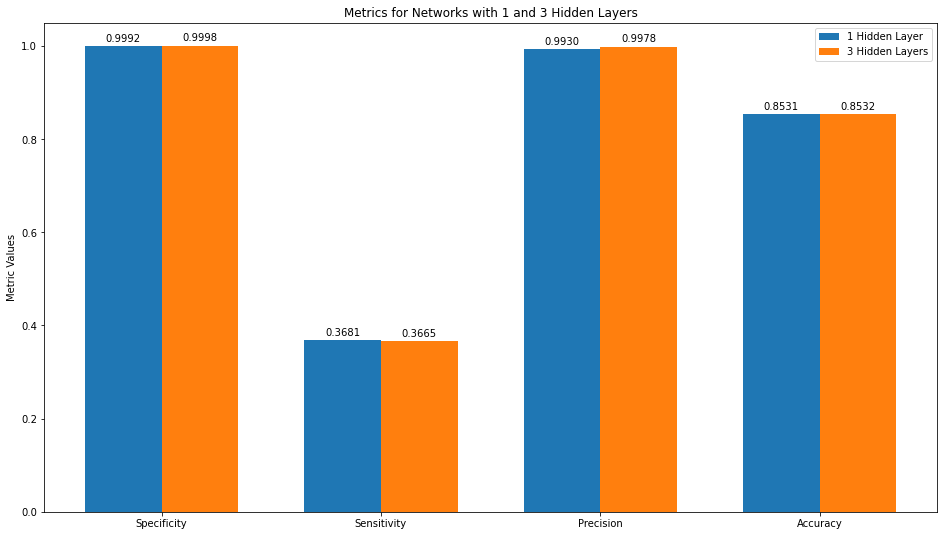

In [93]:
fig, ax = plt.subplots(figsize=(16,9))
width = 0.35
labels = ['Specificity', 'Sensitivity', 'Precision', 'Accuracy']
x = np.arange(len(labels))
nn_1_hidden = [metrics['Specificity'], metrics['Sensitivity'], metrics['Precision'], metrics['Accuracy']]
nn_3_hidden = [nn2_metrics['Specificity'], nn2_metrics['Sensitivity'], nn2_metrics['Precision'], nn2_metrics['Accuracy']]
r1 = ax.bar(x - width/2, nn_1_hidden, width, label='1 Hidden Layer')
r2 = ax.bar(x + width/2, nn_3_hidden, width, label='3 Hidden Layers')
ax.set_ylabel('Metric Values')
ax.set_title('Metrics for Networks with 1 and 3 Hidden Layers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend()
autolabel(r1)
autolabel(r2)
plt.show()

Evaluating the larger, better performing network on the test data.

In [94]:
y_pred = model.predict(x_test_n)
y_pred = np.where(y_pred>=0.7, 1, y_pred)
y_pred = np.where(y_pred<0.7, 0, y_pred)
pred_results = pd.DataFrame({'y_test': y_test_n.values.flatten().astype('int32'),
                             'y_pred': y_pred.flatten().astype('int32') }, index = range(len(y_pred)))

In [95]:
cm = pd.crosstab(pred_results.y_pred, pred_results.y_test)
nn_metrics = {}
nn_metrics['Name'] = "Final/Tuned Neural Network"
nn_metrics['CM'] = cm
nn_metrics['Specificity'] = cm[0][0] / (cm[0][0]+cm[0][1])
nn_metrics['Sensitivity'] = cm[1][1] / (cm[1][1] + cm[1][0])
nn_metrics['Precision'] = cm[1][1] / (cm[1][1] + cm[0][1])
nn_metrics['Accuracy'] = (cm[1][1] + cm[0][0]) / (cm[1][1]+cm[0][0]+cm[1][0]+cm[0][1])
for k,v in nn_metrics.items():
        if k == 'Name':
            print(k + ':', v)
        elif k == 'CM':  
            print("Cost Matrix:",'\n')
            display(v)
        else:
            print(k + ':','\n')
            print(v, '\n')

Name: Final/Tuned Neural Network
Cost Matrix: 



y_test,0,1
y_pred,,
0,186784,36380
1,42,20295


Specificity: 

0.9997751918897798 

Sensitivity: 

0.35809439788266434 

Precision: 

0.9979347986428677 

Accuracy: 

0.8504236122233584 



Saving the fit and tuned neural net model to disk.

In [96]:
model.save('fit-models/neural-net.h5')

In [ ]:
# fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(pred_results.y_test, pred_results.y_pred)
# auc_mlp = auc(fpr_mlp, tpr_mlp)

<a id="unsupervised"></a>
# Unsupervised

<a id="gmm"></a>
## Gaussian Mixed Model

Instantiating the GMM class for 2 components

In [34]:
gmm = GMM(2)

Fitting the GMM instance with the train data

In [35]:
starttime = time.time()
gmm.fit(x_train_s)
print("Training took:", time.time() - starttime, ' seconds')

Training took: 12.8910653591156  seconds


Evaluating the GMM modle on the test data and observing the confusion matrix.

In [36]:
mymetrics.print_metrics(mymetrics.get_metrics(gmm, x_test_s, y_test_s, 'GMM'))

Name: GMM
Cost Matrix: 



actual,0,1
pred,,
0,22983,7587
1,137244,40901


Specificity: 

0.14344024415360707 

Sensitivity: 

0.843528295660782 

Precision: 

0.22959387016194674 

Accuracy: 

0.30608245693888797 



Checking if the model converged during training and it did.

In [37]:
gmm.converged_

True

Storing the model so I can graph it's ROC Curve later.

In [126]:
gmm_model = gmm

In [38]:
dump(gmm, 'fit-models/gmm.joblib')

['fit-models/gmm.joblib']

<a id="kmean"></a>
## K-Means

Below I instantiate sklearn's KMeans class to form 2 clusters, 500 max iterations for a single run, and to run in parallel with 6 threads. I'll use KMeans to try and visualize the data in 2-dimensions.

In [128]:
kmeans = KMeans(n_clusters=2, max_iter=500, random_state=10, n_jobs=6, )

Below I compute the clustering and store the transformed data.

In [129]:
starttime = time.time()
c_space_X = kmeans.fit_transform(x_train_s)
print("Training took:", time.time() - starttime, ' seconds')

/home/jeff/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took: 3.103638172149658  seconds


In [130]:
c_space_X

array([[3.09798968, 7.41189283],
       [2.95024589, 8.13259052],
       [4.77754001, 9.19556802],
       ...,
       [3.59134793, 7.47742959],
       [3.58140857, 7.17732782],
       [4.0862057 , 6.14245789]])

Displayed the transformed data in 'cluster-space'. We can see that the data does not transform or cluster nicely.

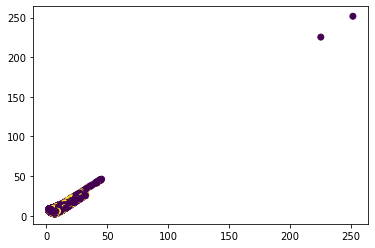

In [131]:
plt.scatter(c_space_X[:,0], c_space_X[:,1], c=y_train_s.values)

The kmeans model is evaluted below on the validation data and the confusion matrix and metric values are displayed. Surprisingly the model performs OK with an accuracy of 73% and more importantly a specificity of 92%. 

In [132]:
mymetrics.print_metrics(mymetrics.get_metrics(kmeans, x_val_s, y_val_s, 'K-Means'))

Name: K-Means
Cost Matrix: 



actual,0,1
pred,,
0,68544,20023
1,6336,2498


Specificity: 

0.9153846153846154 

Sensitivity: 

0.11091869810399183 

Precision: 

0.2827711116142178 

Accuracy: 

0.7293764951078531 



Evaluating the kmeans model on the test data and displaying the results below.

In [136]:
kmeans_metrics = mymetrics.get_metrics(kmeans, x_test_s, y_test_s, 'K-Means')
mymetrics.print_metrics(kmeans_metrics)

Name: K-Means
Cost Matrix: 



actual,0,1
pred,,
0,146706,43334
1,13521,5154


Specificity: 

0.9156134733846355 

Sensitivity: 

0.10629434086784359 

Precision: 

0.27598393574297186 

Accuracy: 

0.7275950458759552 



Saving the fit KMeans model to disk.

In [138]:
dump(kmeans, 'fit-models/kmeans.joblib')

['fit-models/kmeans.joblib']

<a id="pca"></a>
## Primary Component Analysis

Below I'm using sklearn's PCA class to perform dimensionality reduction on the data and visualize it.

In [141]:
pca = PCA(n_components=2, copy=False,svd_solver='arpack', random_state=10 )

Using the PCA model to fit and transform the train data to 2-dimensions.

In [142]:
starttime = time.time()
X_pca = pca.fit_transform(x_train_s)
print("Training took:", time.time() - starttime, ' seconds')

Training took: 0.8555638790130615  seconds


Displaying a sample of the transformed data. We can see there are now two components.

In [143]:
X_pca

array([[-0.64024053,  1.1905603 ],
       [-1.44494128,  0.68232262],
       [-1.82878346,  0.96666395],
       ...,
       [-0.26709744, -2.49881192],
       [ 0.01237634, -0.09202278],
       [ 1.16441675,  2.47051999]])

Plotting the transformed data below. The graph isn't very useful as the data is not linearly separable and viewing it in two dimensions doesn't provide much if any insight.

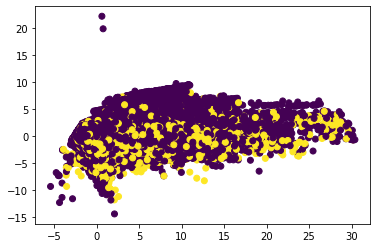

In [160]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_train_s.values)
plt.show()

Below I plot the explained variance, explained variance ration and cummulative explained variance ratio for the two discriminants used.

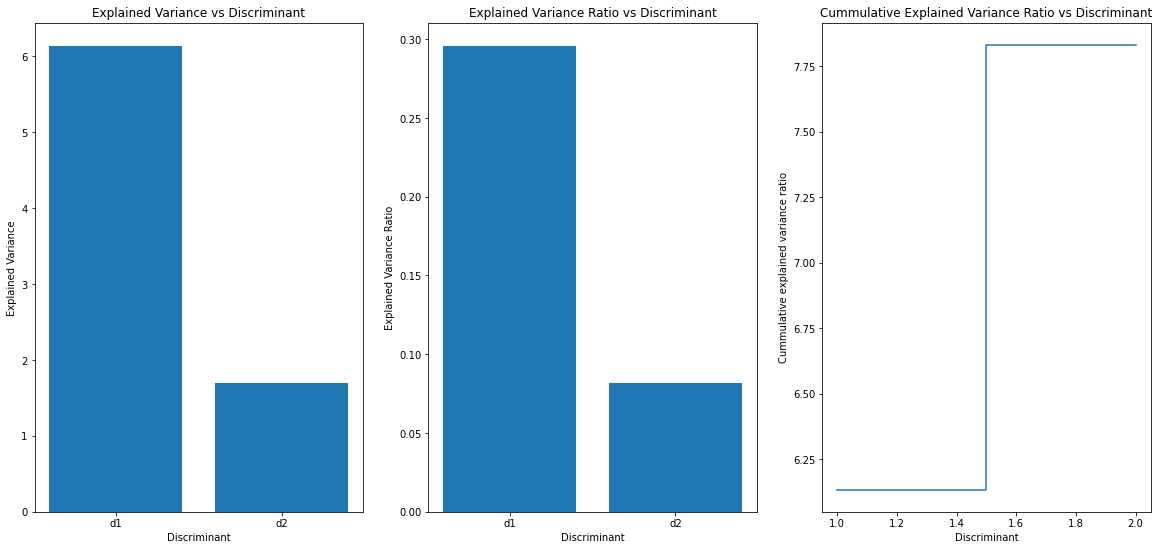

In [164]:
fig=plt.figure(figsize=(20,9))
ax = fig.add_subplot(1,3,1)


ax.set_title("Explained Variance vs Discriminant")
ax.bar([1,2], pca.explained_variance_, align='center')
ax.set_ylabel('Explained Variance')
ax.set_xticks([1,2])
ax.set_xticklabels(['d1', 'd2'])
ax.set_xlabel('Discriminant')

ax = fig.add_subplot(1,3,2)
ax.bar([1,2], pca.explained_variance_ratio_)
ax.set_title("Explained Variance Ratio vs Discriminant")
ax.set_ylabel('Explained Variance Ratio')
ax.set_xticks([1,2])
ax.set_xticklabels(['d1', 'd2'])
ax.set_xlabel('Discriminant')

cum_expl_var = np.cumsum(pca.explained_variance_)
ax = fig.add_subplot(1,3,3)
ax.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')
ax.set_title("Cummulative Explained Variance Ratio vs Discriminant")
ax.set_ylabel('Cummulative explained variance ratio')
ax.set_xlabel('Discriminant')
plt.show()

Writing the PCA model to disk.

In [165]:
dump(pca,'fit-models/pca.joblib')

['fit-models/pca.joblib']

<a id="kpca"></a>
## Kernel Primary Component Analysis

I'm using Kernel PCA to project the train data onto 2 dimensions. Because of the data's size and that the kernel matrix is of size (n x n) where n is the number of examples I keep recieving a memory error. I've found that 15,000 examples is the max I can use without recieving the memory error. I create a subset of the train data by random selection and select the corresponding targets into X and y subset.

In [18]:
X_subset = x_train_s.sample(15000)
y_subset = y_train_s.loc[X_subset.index]

Creating possible values to use for the hyperparameter gamma.

In [27]:
Gamma = [0.0001, 0.001, 0.005, 0.01, 0.1, 1, 5, 10]
transformed_datasets = []

Training Kernel PCA models with different values for gamma. Each model used a radial basis function kernel and arpack solver. 

In [28]:
starttime = time.time()
for g in Gamma:
    kpca = KernelPCA(n_components=2, kernel='rbf', eigen_solver='arpack', gamma=g, random_state=10, copy_X=False, n_jobs=6)
    X_kpca = kpca.fit_transform(X_subset)
    transformed_datasets.append(X_kpca)
print('Training took:', time.time() - starttime, 'seconds')

Training took: 82.20572233200073 seconds


Below I plot the train data sample projected onto 2-dimensions for different values of gamma. None of the clustering looks great and it doesn't seem worth while saving one of the models to disk.

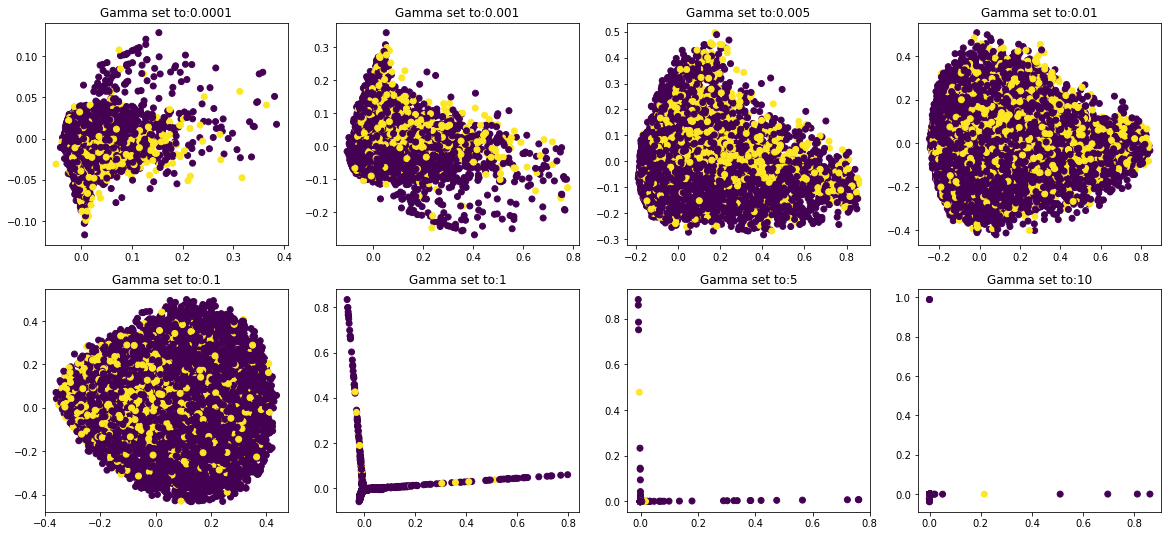

In [29]:
fig=plt.figure(figsize=(20,9))
i = 1
for data in transformed_datasets:
    ax = fig.add_subplot(2,4,i)
    ax.scatter(data[:,0], data[:,1], c = y_subset.values)
    ax.set_title('Gamma set to:' + str(Gamma[i-1]))
    i = i + 1 

<a id="results"></a>
# Results

Loading the fit and final models from disc.

In [7]:
lr = load('fit-models/logistic-regression.joblib')
ada = load('fit-models/adaboost.joblib')
rf = load('fit-models/random-forest.joblib')
linear_svc = load('fit-models/linear-svc.joblib')
kernel_svc = load('fit-models/kernel-svc.joblib')
gmm = load('fit-models/gmm.joblib')
kmeans = load('fit-models/kmeans.joblib')
nn = keras.models.load_model('fit-models/neural-net.h5')

Calculating the false positive rate, true positive rate, and area under the curve for the TensorFlow Neural Network

In [84]:
y_pred_nn = nn.predict(x_test_n).ravel()
fpr_nn, tpr_nn, _ = roc_curve(y_test_n, y_pred_nn)
auc_nn = auc(fpr_nn, tpr_nn)

<a id='roc'></a>
## ROC Curves

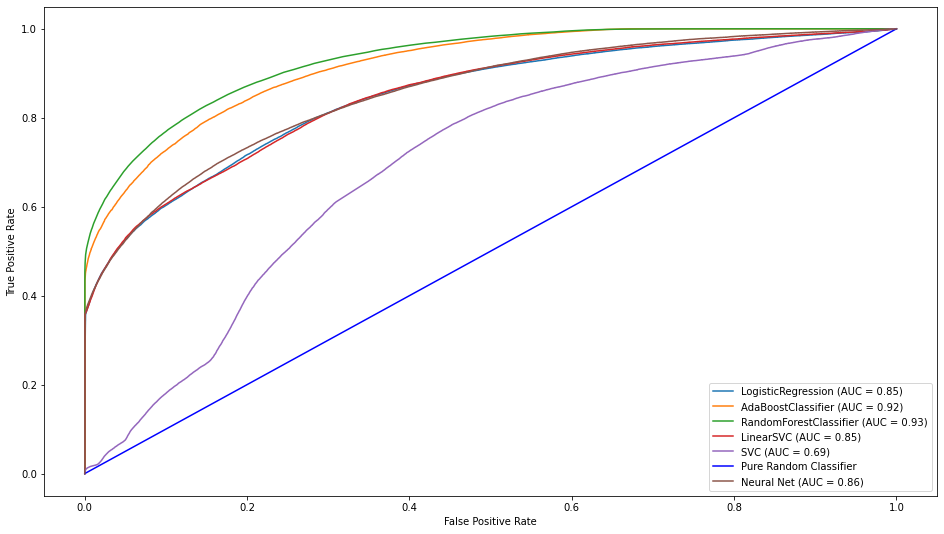

In [83]:
fig, ax = plt.subplots(figsize=(16,9)) 
plot_roc_curve(lr, x_test_s, y_test_s, ax=ax)
plot_roc_curve(ada, x_test_s, y_test_s, ax=ax)
plot_roc_curve(rf, x_test_s, y_test_s, ax=ax)
plot_roc_curve(linear_svc, x_test_s, y_test_s, ax=ax)
plot_roc_curve(kernel_svc, x_test_s,y_test_s, ax=ax)
ax.plot([0,1], [0,1], 'b-', label='Pure Random Classifier')
ax.plot(fpr_nn, tpr_nn, label='Neural Net (AUC = {:.2f})'.format(auc_nn))
plt.legend()
plt.show()

<a id='metricComparisons'></a>
## Metric Comparisons

Getting metric dictionaries for each of the finished models

In [8]:
lr_metrics = mymetrics.get_metrics(lr, x_test_s, y_test_s, 'Logistic Regression')
ada_metrics = mymetrics.get_metrics(ada, x_test_s, y_test_s, 'AdaBoost')
rf_metrics = mymetrics.get_metrics(rf, x_test_s, y_test_s, 'Random Forest')
lsvc_metrics = mymetrics.get_metrics(linear_svc, x_test_s, y_test_s, 'Linear SVC')
ksvc_metrics = mymetrics.get_metrics(kernel_svc, x_test_s, y_test_s, 'Kernel SVC')
nn_metrics = mymetrics.get_metrics(nn, x_test_n, y_test_n, 'Neural Network')

In [10]:
metrics_arr = [lr_metrics, ada_metrics, rf_metrics, lsvc_metrics, ksvc_metrics, nn_metrics]
sensitivities = []
specificities = []
accuracies = []
precisions = []
names = []
for metric_dict in metrics_arr:
    sensitivities.append(metric_dict['Sensitivity'])
    specificities.append(metric_dict['Specificity'])
    accuracies.append(metric_dict['Accuracy'])
    precisions.append(metric_dict['Precision'])
    names.append(metric_dict['Name'])

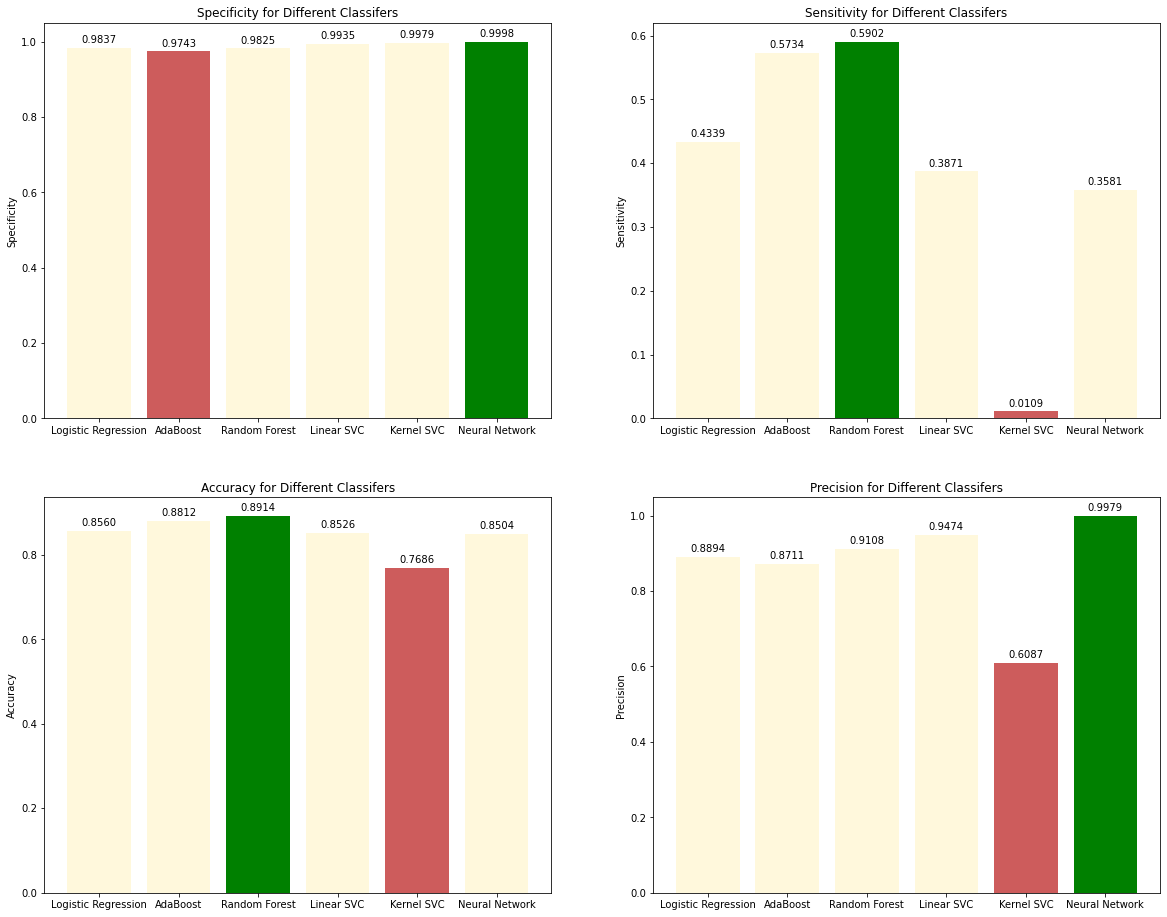

In [48]:
colors = ['cornsilk','cornsilk','cornsilk','cornsilk','cornsilk','cornsilk']
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(2,2,1)
labels = names
x = np.arange(len(labels))
max_idx = np.argmax(specificities)
min_idx = np.argmin(specificities)
colors[max_idx] = 'green'
colors[min_idx] = 'indianred'
rects = ax.bar(x, specificities, color=colors)
ax.set_ylabel('Specificity')
ax.set_title('Specificity for Different Classifers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
autolabel(rects)

colors = ['cornsilk','cornsilk','cornsilk','cornsilk','cornsilk','cornsilk']
ax = fig.add_subplot(2,2,2)
labels = names
x = np.arange(len(labels))
max_idx = np.argmax(sensitivities)
min_idx = np.argmin(sensitivities)
colors[max_idx] = 'green'
colors[min_idx] = 'indianred'
rects = ax.bar(x, sensitivities, color=colors)
ax.set_ylabel('Sensitivity')
ax.set_title('Sensitivity for Different Classifers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
autolabel(rects)

colors = ['cornsilk','cornsilk','cornsilk','cornsilk','cornsilk','cornsilk']
ax = fig.add_subplot(2,2,3)
labels = names
x = np.arange(len(labels))
max_idx = np.argmax(accuracies)
min_idx = np.argmin(accuracies)
colors[max_idx] = 'green'
colors[min_idx] = 'indianred'
rects = ax.bar(x, accuracies, color=colors)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Different Classifers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
autolabel(rects)

colors = ['cornsilk','cornsilk','cornsilk','cornsilk','cornsilk','cornsilk']
ax = fig.add_subplot(2,2,4)
labels = names
x = np.arange(len(labels))
max_idx = np.argmax(precisions)
min_idx = np.argmin(precisions)
colors[max_idx] = 'green'
colors[min_idx] = 'indianred'
rects = ax.bar(x, precisions, color=colors)
ax.set_ylabel('Precision')
ax.set_title('Precision for Different Classifers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
autolabel(rects)


plt.show()